# Purpose


### 2023-05-25
Now that I'll be training on multiple campaigns, I need to pull input data for different subreddits at different dates. So we need to create a process to get the inference data in an automated way (instead of running all users and all subreddits for each partition needed).

Selecting only the users & subreddits with labels will make queries faster and help us iterate more quickly to try new and better features.

Provenance:
- `djb_03.07-2023-05-01-target_subreddit_training_data_and_run_baseline_models_add_tos_pct.ipynb`


# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%autosave 90

Autosaving every 90 seconds


In [3]:
from datetime import datetime
import gc
import logging
from logging import info
import os
from pathlib import Path
import json

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
import joblib
from typing import Tuple, Union

from subclu.models.nn_annoy import AnnoyIndex
from subclu.utils.eda import get_venn_sets2

from matplotlib_venn import venn2_unweighted

from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, joblib, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
joblib		v: 1.0.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [4]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define local path for this model outputs

In [5]:
manual_model_timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')
path_this_model = get_project_subfolder(
    f"data/models/pn_model/pn_manual_test_{manual_model_timestamp}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
print(path_this_model)

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024


# Define key inputs
Use these throughout the process to filter/target specific subreddits, geos, & users

In [6]:
# l_target_subreddits = ['ich_iel']

# # We would want to add an automated way to pick these ANN subs, but look them up manually for now
# l_target_ann_subreddits = ['fragreddit', 'de']

# l_target_geos = ['DE']

# Load & reshape data

## Load labeled data to extract parameters we need
We need to get data from the labeled table to figure out input features like:
- Date to pull features (1 day before SEND date)
- Which subreddits to pull
- Which USERS to pull

In [7]:
table_training_labels = "reddit-employee-datasets.david_bermejo.pn_training_data_20230515"

In [8]:
%%time
%%bigquery df_label_dt --project data-prod-165221

-- Get send dates so we can calculate needed dates for input labels
SELECT
    pt_send
    , (pt_send - 1) AS pt_train
    , COUNT(DISTINCT pn_id) AS campaign_count
    , COUNT(DISTINCT user_id) AS user_count
    , SUM(send) AS send_total
    , SUM(receive) AS receive_total
    , SUM(click) AS click_total
FROM `reddit-employee-datasets.david_bermejo.pn_training_data_20230515` 
GROUP BY 1
ORDER BY user_count DESC

Downloading: 100%|██████████| 10/10 [00:00<00:00, 10.97rows/s]

CPU times: user 108 ms, sys: 39.2 ms, total: 147 ms
Wall time: 5.79 s


In [9]:
print(df_label_dt.shape)

style_df_numeric(df_label_dt)

(10, 7)


,pt_send,pt_train,campaign_count,user_count,send_total,receive_total,click_total
0,2023-05-10,2023-05-09,4,"418,475","442,845","402,125","18,827"
1,2022-12-02,2022-12-01,1,"285,817","285,817","253,583","13,229"
2,2023-05-05,2023-05-04,2,"126,165","126,165","114,802","4,595"
3,2023-04-25,2023-04-24,1,"89,288","89,288","80,518","4,458"
4,2023-05-09,2023-05-08,1,"80,088","80,088","71,273","5,359"
5,2023-02-20,2023-02-19,1,"78,447","78,447","71,781","2,373"
6,2023-04-18,2023-04-17,1,"74,027","74,027","67,817","1,448"
7,2023-05-08,2023-05-07,1,"70,430","70,430","63,828","1,113"
8,2023-05-12,2023-05-11,1,"49,850","49,850","45,616","3,155"
9,2023-03-01,2023-02-28,2,"41,443","75,992","70,824","4,215"


## Run loops to populate tables with inference data
Once we have the parameters we need, then let's run loops with the correct inputs so that we can get the featuers for the 
- subreddits
- users
- user<>subreddits
    - Time-on-Subreddit

at the CORRECT time (one day **BEFORE** send date)

---

NOTE: for the initial runs, I ran the loops manually in SQL.
See the folder with queries here:
- subclu/pn_models/sql_training

In [10]:
sorted(df_label_dt['pt_train'].astype(str).unique())

['2022-12-01',
 '2023-02-19',
 '2023-02-28',
 '2023-04-17',
 '2023-04-24',
 '2023-05-04',
 '2023-05-07',
 '2023-05-08',
 '2023-05-09',
 '2023-05-11']

In [ ]:
# for each pt_train date, run

In [ ]:
#

# Query with inputs AND labels

Note that for now (2023-05-29) we'll be excluding subreddit-level columns because for training we don't always get that data at the user-level.

In [34]:
%%time
%%bigquery df_train_raw1 --project data-prod-165221

-- F. Select lables and input data to train models
--   v2: use existing inference table as start

WITH
user_subreddit_with_activity AS (
    SELECT
        pt_send
        , t.pn_id
        , t.correlation_id
        , COALESCE((t.pt_send - 1), ft.pt) AS pt
        , COALESCE(t.user_id, ft.user_id) AS user_id
        , COALESCE(t.target_subreddit, ft.target_subreddit) AS target_subreddit
        , t.send
        , t.receive
        , t.click

        , ft.* EXCEPT(
            target_subreddit, user_id, pt
            -- SUBREDDIT features to skip for now:
            , posts_l7, posts_l28, posts_log_l7, posts_log_l28
            , users_l7, users_l14, users_l28, users_log_l7, users_log_l14, users_log_l28
            , comments_l7, comments_l28, comments_log_l7, comments_log_l28
            , seo_users_l28, seo_users_pct_l28, loggedin_users_l28, loggedin_users_pct_l28
            , ios_users_l28, ios_users_pct_l28, android_users_l28, android_users_pct_l28
            , votes_l7, votes_l28, votes_log_l7, votes_log_l28
        )
    FROM `reddit-employee-datasets.david_bermejo.pn_training_data_20230515` AS t
        INNER JOIN `reddit-employee-datasets.david_bermejo.pn_ft_all_20230529` AS ft
            ON (t.pt_send - 1) = ft.pt 
                AND t.user_id = ft.user_id 
                AND LOWER(t.target_subreddit) = ft.target_subreddit
    WHERE (COALESCE(t.receive, 0) + COALESCE(t.click, 0)) >= 1
        -- TODO(djb): go back and fix dupes later: EXCLUDE campaigns that have duplicate data: 
        AND pt_send NOT IN ('2023-03-01', '2023-05-10')
)
, user_subreddit_missing_activity AS (
    -- We need thid additional query because some users received a PN, but don't seem to have previous activity with that subreddit
    --  in the target window we created. So we need to at least get the USER-level features for them
    SELECT
        t.*
    FROM (
        SELECT 
            t.pt_send
            , t.pn_id
            , t.correlation_id
            , COALESCE((t.pt_send - 1), ft.pt) AS pt
            , COALESCE(t.user_id, ft.user_id) AS user_id
            , COALESCE(t.target_subreddit, ft.target_subreddit) AS target_subreddit
            , t.send
            , t.receive
            , t.click

            , ft.* EXCEPT(
                target_subreddit, user_id, pt
                -- SUBREDDIT features to skip for now:
                , posts_l7, posts_l28, posts_log_l7, posts_log_l28
                , users_l7, users_l14, users_l28, users_log_l7, users_log_l14, users_log_l28
                , comments_l7, comments_l28, comments_log_l7, comments_log_l28
                , seo_users_l28, seo_users_pct_l28, loggedin_users_l28, loggedin_users_pct_l28
                , ios_users_l28, ios_users_pct_l28, android_users_l28, android_users_pct_l28
                , votes_l7, votes_l28, votes_log_l7, votes_log_l28
            )
        FROM `reddit-employee-datasets.david_bermejo.pn_training_data_20230515` AS t
        LEFT JOIN `reddit-employee-datasets.david_bermejo.pn_ft_all_20230529` AS ft
            ON (t.pt_send - 1) = ft.pt 
                AND t.user_id = ft.user_id 
                AND LOWER(t.target_subreddit) = ft.target_subreddit
        WHERE (COALESCE(t.receive, 0) + COALESCE(t.click, 0)) >= 1
            AND ft.target_subreddit IS NULL
            -- TODO(djb): go back and fix dupes later: EXCLUDE campaigns that have duplicate data: 
            AND pt_send NOT IN ('2023-03-01', '2023-05-10')
    ) AS t
        -- Only keep subreddits that have some behavior metrics
        INNER JOIN `reddit-employee-datasets.david_bermejo.pn_ft_user_20230529` AS ft
            ON (t.pt_send - 1) = ft.pt 
                AND t.user_id = ft.user_id
)
, final_table AS (
    -- Combine users w/ and w/o activity into a single table
    SELECT * FROM user_subreddit_with_activity
    UNION ALL
    SELECT * FROM user_subreddit_missing_activity
)


SELECT 
    COALESCE(click, 0) AS click
    , * EXCEPT(pt_send, click)
FROM final_table;

Downloading: 100%|██████████| 750935/750935 [00:05<00:00, 146782.78rows/s]


CPU times: user 2.06 s, sys: 1.29 s, total: 3.36 s
Wall time: 6.47 s


In [118]:
%%time
%%bigquery df_train_raw --project data-prod-165221

-- F. Select lables and input data to train models
--   v1 Start with training labels to skip inference table

DECLARE PT_FEATURES DEFAULT [
    DATE('2022-12-01')
    , DATE('2023-02-19')
    , DATE('2023-02-28')
    , DATE('2023-04-17')
    , DATE('2023-04-24')
    , DATE('2023-05-04')
    , DATE('2023-05-07')
    , DATE('2023-05-08')
    , DATE('2023-05-09')
    , DATE('2023-05-11')
];
-- Need explicit max & min for legacy user cohorts
DECLARE PT_FEATURES_MAX DEFAULT TIMESTAMP((SELECT MAX(dt) FROM UNNEST(PT_FEATURES) AS dt));
DECLARE PT_FEATURES_MIN DEFAULT TIMESTAMP((SELECT MIN(dt) FROM UNNEST(PT_FEATURES) AS dt));

WITH
train_labels AS (
    SELECT
        pt_send
        , (pt_send - 1) AS pt
        , user_id
        , target_subreddit
        , t.send
        , t.receive
        , t.click
        , t.pn_id
        , t.correlation_id
    FROM `reddit-employee-datasets.david_bermejo.pn_training_data_20230515` AS t
    WHERE (COALESCE(t.receive, 0) + COALESCE(t.click, 0)) >= 1
        AND (pt_send - 1) IN UNNEST(PT_FEATURES)
    
        -- TODO(djb): go back and fix dupes later: EXCLUDE campaigns that have duplicate data??
        -- AND pt_send NOT IN ('2023-03-01', '2023-05-10')
)

, subreddit_ft AS (
    -- Query A
    SELECT
        s.* EXCEPT(
            relevant_geo_country_codes, relevant_geo_country_code_count
            -- TODO(djb): try encoding rating & topics later or let model ecode them
            , over_18, curator_rating, curator_topic_v2
        )
    FROM `reddit-employee-datasets.david_bermejo.pn_ft_subreddits_20230525` AS s
    WHERE s.pt IN UNNEST(PT_FEATURES)

    -- For testing, we can limit to only the top subreddits
    -- ORDER BY users_l7 DESC
    -- LIMIT 1000
)
, user_subreddit_ft AS (
    -- Query C
    SELECT
        us.* EXCEPT(pt_window_start)
        -- For inference, keep raw country
        
    FROM `reddit-employee-datasets.david_bermejo.pn_ft_user_subreddit_20230529` AS us
        
    WHERE us.pt IN UNNEST(PT_FEATURES)
        -- TODO(djb): for Inference Only keep users from target geos
        -- AND COALESCE(us.user_geo_country_code, "") IN UNNEST(TARGET_COUNTRY_CODES)
)
, user_ft AS (
    -- Query B
    -- TODO(djb): append cohorts to user-level table from the start!
    SELECT 
        CASE
            WHEN cl.legacy_user_cohort = 'new' THEN 1
            WHEN cl.legacy_user_cohort = 'resurrected' THEN 2
            WHEN cl.legacy_user_cohort = 'casual' THEN 3
            WHEN cl.legacy_user_cohort IS NULL THEN 4  -- '_missing_' or 'dead'
            WHEN cl.legacy_user_cohort = 'core' THEN 5
            ELSE 0
        END AS legacy_user_cohort_ord
        , u.*
    FROM (
            SELECT *
            FROM `reddit-employee-datasets.david_bermejo.pn_ft_user_20230529`
            WHERE pt IN UNNEST(PT_FEATURES)
        ) AS u
        LEFT JOIN (
            -- get USER cohort, Legacy
            SELECT user_id, legacy_user_cohort, pt
            FROM `data-prod-165221.attributes_platform.user_rolling_legacy_user_cohorts`
            WHERE pt BETWEEN PT_FEATURES_MIN AND PT_FEATURES_MIN
        ) AS cl
            ON u.user_id = cl.user_id AND cl.pt = TIMESTAMP(u.pt)
)
# , final_table AS (
#     SELECT
#         -- These index columns are needed for the final outputs (not inference)
#         COALESCE(u.pt, us.pt) AS pt
#         , us.target_subreddit_id
#         , us.target_subreddit
#         , COALESCE(u.user_id, us.user_id) AS user_id
#         , COALESCE(u.user_geo_country_code, us.user_geo_country_code) AS user_geo_country_code

#         -- The rest of the columns should be used for modeling inference
#         , u.* EXCEPT(pt, user_id, user_geo_country_code)
#         , us.* EXCEPT(pt, user_id, target_subreddit, target_subreddit_id, user_geo_country_code)
        
#         , s.* EXCEPT(subreddit_id, subreddit_name, pt)

#     -- TODO(djb): training: Start with User-level features, b/c we might need to fill nulls for MISSING target_subreddits
#     --   For inference, we might want to start with user<>subreddit features and only do inner join with subreddit features
#     FROM user_ft AS u
#         LEFT JOIN user_subreddit_ft AS us
#             ON us.user_id = u.user_id  AND us.pt = u.pt
#         -- Subreddit features. limit subreddits to score by using inner join
#         LEFT JOIN subreddit_ft AS s
#             ON us.target_subreddit_id = s.subreddit_id AND us.pt = s.pt
# )
, final_table_with_labels AS (
    SELECT
        -- Training labels
        t.pt_send
        , t.send
        , t.receive
        , t.click
        , t.pn_id
        , t.correlation_id

        -- These index columns are needed for the final outputs (not inference)        
        , COALESCE(u.pt, us.pt) AS pt
        , us.target_subreddit_id
        , COALESCE(LOWER(t.target_subreddit), us.target_subreddit) AS target_subreddit
        , COALESCE(t.user_id, u.user_id, us.user_id) AS user_id
        , COALESCE(u.user_geo_country_code, us.user_geo_country_code) AS user_geo_country_code

        -- The rest of the columns should be used for modeling inference
        , u.* EXCEPT(pt, user_id, user_geo_country_code)
        , us.* EXCEPT(pt, user_id, target_subreddit, target_subreddit_id, user_geo_country_code)
        
        -- Exclude subreddit features that are raw counts (log features should be better)
        , s.users_log_l28
        , s.seo_users_pct_l28
        , s.loggedin_users_pct_l28
        , s.ios_users_pct_l28
        , s.android_users_pct_l28
#         , s.* EXCEPT(
#             subreddit_id, subreddit_name, pt
#             , votes_l7, votes_l28
#             , ios_users_l28, android_users_l28
#             , loggedin_users_l28, seo_users_l28
#             , comments_l7, comments_l28
#             , users_l7, users_l14, users_l28
#             , posts_l7, posts_l28
#         )
    FROM train_labels AS t
        LEFT JOIN user_ft AS u
            ON t.pt = u.pt AND t.user_id = u.user_id
        LEFT JOIN user_subreddit_ft AS us
            ON t.user_id = us.user_id 
                AND t.pt = us.pt
                AND LOWER(t.target_subreddit) = us.target_subreddit
        -- Subreddit features. limit subreddits to score by using inner join
        LEFT JOIN subreddit_ft AS s
            ON LOWER(t.target_subreddit) = s.subreddit_name 
                AND t.pt = s.pt
)


SELECT 
    COALESCE(click, 0) AS click
    , COALESCE(subscribed, 0) AS subscribed
    , * EXCEPT(
        click, subscribed
        -- Other columns that have log transform OR percent
        , num_post_consumes_30, num_post_consumes_home_30
        , num_post_consumes_community_30, num_post_consumes_post_detail_30
        , num_post_consumes_nsfw_30
        , user_clicks_pn_t7
        , user_clicks_trnd_t7
        , screen_view_count_14d
        , us_trend_pn_receive_l14
        , us_screenviews_l14
        , us_post_screenviews_l14
        , us_distinct_posts_viewed_l14
    )
FROM final_table_with_labels
WHERE 1=1
    -- Drop users without recent activity because there's no data for model to learn from
    AND (
        click = 1
        AND user_receives_pn_t30 IS NOT NULL
        OR log_post_consumes_30 IS NOT NULL
    )
ORDER BY receive DESC, click DESC, num_post_consumes_30 DESC
;

Downloading: 100%|██████████| 1217703/1217703 [00:06<00:00, 174306.12rows/s]


CPU times: user 3.28 s, sys: 1.51 s, total: 4.8 s
Wall time: 23.6 s


In [119]:
print(df_train_raw.shape)
# df_train_raw.info()

(1217703, 51)


In [120]:
counts_describe(df_train_raw[['correlation_id', 'pn_id', 'user_id', 'target_subreddit',  'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
correlation_id,object,"1,217,703","1,184,876",97.30%,0,0.00%
pn_id,object,"1,217,703",15,0.00%,0,0.00%
user_id,object,"1,217,703","1,074,907",88.27%,0,0.00%
target_subreddit,object,"1,217,703",13,0.00%,0,0.00%
click,int64,"1,217,703",2,0.00%,0,0.00%
subscribed,int64,"1,217,703",2,0.00%,0,0.00%


It looks like there are some duplicates at the TRAIN table... remove them for now to prevent errors or extra weight for dupes


In [121]:
mask_dupes = (
    df_train_raw.duplicated(subset=['user_id', 'correlation_id'], keep=False)
)
mask_dupes.sum()

65654

In [122]:
(
    df_train_raw
    [mask_dupes]
    .sort_values(by=['user_id'])
    .iloc[:5, :26]
)

,click,subscribed,pt_send,send,receive,pn_id,correlation_id,pt,target_subreddit_id,target_subreddit,user_id,user_geo_country_code,legacy_user_cohort_ord,screen_view_count_14d_log,user_receives_pn_subreddit_count_t7,user_receives_pn_t7,user_receives_pn_t14,user_receives_pn_t30,log_user_clicks_pn_t7,log_user_clicks_trnd_t7,log_post_consumes_30,log_num_post_consumes_home_30,pct_post_consumes_home_30,pct_post_consumes_community_30,pct_post_consumes_post_detail_30,pct_post_consumes_ios_30
265464,0,0,2023-03-01,1,1.0,2023-03-01-TheMandolorianTV:-https://www.reddit.com/r/TheMandalorianTV/comments/11cjv6v/and_the_journey_continues/,8e28a838-0466-4fbb-a171-c7f43214bf79,2023-02-28,None,themandaloriantv,t2_1000ze,GB,4,3.091042,9,34,66,117,0.000000,0.000000,9.382359,9.041330,0.711014,0.131778,0.000000,1.0
265480,0,0,2023-03-01,1,1.0,2023-03-01-TheMandolorianTV:-https://www.reddit.com/r/TheMandalorianTV/comments/11cjv6v/and_the_journey_continues/,8e28a838-0466-4fbb-a171-c7f43214bf79,2023-02-28,None,themandaloriantv,t2_1000ze,GB,4,3.091042,9,34,66,117,0.000000,0.000000,9.382359,9.041330,0.711014,0.131778,0.000000,1.0
37516,1,0,2023-05-10,1,1.0,2023-05-10-Zelda + AI = 🤯-https://www.reddit.com/r/midjourney/comments/13cjrws/zelda_breath_of_the_wild_movie_stills/,a6aaf548-fa75-40c2-9be5-b5b5aa7a5743,2023-05-09,None,midjourney,t2_1008fr,CA,4,2.708050,4,68,133,259,2.302585,2.079442,7.825645,7.130099,0.498602,0.284459,0.071115,1.0
37515,1,0,2023-05-10,1,1.0,2023-05-10-Zelda + AI = 🤯-https://www.reddit.com/r/midjourney/comments/13cjrws/zelda_breath_of_the_wild_movie_stills/,a6aaf548-fa75-40c2-9be5-b5b5aa7a5743,2023-05-09,None,midjourney,t2_1008fr,CA,4,2.708050,4,68,133,259,2.302585,2.079442,7.825645,7.130099,0.498602,0.284459,0.071115,1.0
37508,1,0,2023-05-10,1,1.0,2023-05-10-Zelda + AI = 🤯-https://www.reddit.com/r/midjourney/comments/13cjrws/zelda_breath_of_the_wild_movie_stills/,9c109296-616e-4c58-a632-4e16911e6e1c,2023-05-09,None,midjourney,t2_1008fr,CA,4,2.708050,4,68,133,259,2.302585,2.079442,7.825645,7.130099,0.498602,0.284459,0.071115,1.0


In [177]:
%%time

# reset index after dropping duplicates! other downstream functions expect an ordered numeric index
df_train = (
    df_train_raw
    .drop_duplicates(subset=['user_id', 'correlation_id'], keep=False)
    .drop_duplicates(subset=['user_id', 'pn_id'], keep=False)
    .reset_index(drop=True)
    .copy()
)

df_train.shape

CPU times: user 1.79 s, sys: 368 ms, total: 2.16 s
Wall time: 2.15 s


(1152045, 51)

In [178]:
counts_describe(df_train[['correlation_id', 'pn_id', 'user_id', 'target_subreddit',  'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
correlation_id,object,"1,152,045","1,152,045",100.00%,0,0.00%
pn_id,object,"1,152,045",14,0.00%,0,0.00%
user_id,object,"1,152,045","1,050,127",91.15%,0,0.00%
target_subreddit,object,"1,152,045",13,0.00%,0,0.00%
click,int64,"1,152,045",2,0.00%,0,0.00%
subscribed,int64,"1,152,045",2,0.00%,0,0.00%


In [179]:
mask_dupes2 = (
    df_train.duplicated(subset=['user_id', 'correlation_id'], keep=False)
)
mask_dupes3 = (
    df_train.duplicated(subset=['user_id', 'pn_id'], keep=False)
)

print(mask_dupes2.sum())
assert 0 == mask_dupes2.sum()
print(mask_dupes3.sum())
assert 0 == mask_dupes3.sum()

0
0


In [180]:
style_df_numeric(
    df_train.drop(['pn_id', 'correlation_id', 'pt_send', 'pt'], axis=1)
    .head()
)

,click,subscribed,send,receive,target_subreddit_id,target_subreddit,user_id,user_geo_country_code,legacy_user_cohort_ord,screen_view_count_14d_log,user_receives_pn_subreddit_count_t7,user_receives_pn_t7,user_receives_pn_t14,user_receives_pn_t30,log_user_clicks_pn_t7,log_user_clicks_trnd_t7,log_post_consumes_30,log_num_post_consumes_home_30,pct_post_consumes_home_30,pct_post_consumes_community_30,pct_post_consumes_post_detail_30,pct_post_consumes_ios_30,pct_post_consumes_android_30,pct_post_consumes_nsfw_30,num_post_consumes_ios_30,num_post_consumes_android_30,sub_dau_perc_l28,perc_by_country_sd,us_screenviews_l14_log,us_distinct_posts_viewed_l14_log,us_post_screenviews_l14_log,us_trend_pn_receive_l14_log,us_days_active_ios_l30_pct,us_android_days_active_l30_pct,us_upvotes_l14,us_comments_l14,us_posts_l14,us_trend_pn_click_l14,us_sessions_l14,us_ios_days_active_l30,us_android_days_active_l30,us_days_active_l30,users_log_l28,seo_users_pct_l28,loggedin_users_pct_l28,ios_users_pct_l28,android_users_pct_l28
0,1,1,1,1.00,t5_37k29,ich_iel,t2_2pu92lu5,DE,5,3,23,354,752,"1,910",4.80,2.48,11.80,11.18,0.54,0.09,0.00,0.00,1.00,0.05,0,"133,045",0.62,12,0.69,3.87,3.97,0.00,0.00%,100.00%,96.00,0.00,0.00,0.00,24.00,0.00,28.00,28.00,13.83,2.23%,56.45%,33.00%,23.71%
1,1,0,1,1.00,t5_2rsu8,eurovision,t2_12vg45ax,GB,4,3,1,1,10,11,0.00,0.00,11.54,10.99,0.58,0.07,0.00,0.00,1.00,0.04,0,"102,538",0.27,2,0.00,0.00,0.00,0.00,0.00%,100.00%,-,-,-,-,-,0.00,1.00,1.00,12.73,26.06%,59.17%,31.85%,21.26%
2,1,0,1,1.00,t5_5zvcfk,midjourney,t2_1nk26oym,CA,4,3,2,7,32,65,2.56,0.00,11.38,11.31,0.93,0.03,0.00,0.00,1.00,0.03,0,"87,459",0.04,-0,0.00,0.69,0.69,0.00,0.00%,100.00%,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,14.57,22.07%,64.66%,34.80%,21.88%
3,1,1,1,1.00,t5_5zvcfk,midjourney,t2_9v2zh2rf,CA,4,3,7,20,78,227,2.77,0.00,11.37,11.24,0.88,0.03,0.04,1.00,0.00,0.02,"86,393",0,0.04,-0,0.00,1.39,1.95,0.00,100.00%,0.00%,3.00,0.00,0.00,0.00,13.00,21.00,0.00,21.00,14.57,22.07%,64.66%,34.80%,21.88%
4,1,1,1,1.00,t5_u8wq5,themandaloriantv,t2_lv06oxzo,GB,4,3,1,1,1,2,0.00,0.00,11.36,11.33,0.98,0.02,0.00,0.00,1.00,0.03,0,"85,728",0.10,3,0.00,0.00,0.00,0.00,-,-,-,-,-,-,-,-,-,-,13.53,22.33%,69.47%,42.31%,20.04%


# Basic EDA

In [181]:
counts_describe(
    df_train
    .drop(['pn_id', 'correlation_id', 'pt_send', 'pt'], axis=1)
)

,dtype,count,unique,unique-percent,null-count,null-percent
click,int64,"1,152,045",2,0.00%,0,0.00%
subscribed,int64,"1,152,045",2,0.00%,0,0.00%
send,int64,"1,152,045",1,0.00%,0,0.00%
receive,float64,"1,152,033",1,0.00%,12,0.00%
target_subreddit_id,object,"456,066",13,0.00%,"695,979",60.41%
target_subreddit,object,"1,152,045",13,0.00%,0,0.00%
user_id,object,"1,152,045","1,050,127",91.15%,0,0.00%
user_geo_country_code,object,"1,152,045",199,0.02%,0,0.00%
legacy_user_cohort_ord,int64,"1,152,045",5,0.00%,0,0.00%
screen_view_count_14d_log,float64,"1,152,045",21,0.00%,0,0.00%


In [182]:
# in prev run we had 97% of users with a consume in L30 days
print(247441 / 253583)

# This time we removed those users because there's nothing the model can learn from inactive users
#. For inference, we will be excluding those users
print(1152045 / 1176509)  # if we didn't exclude them, we'd get 97% again

0.9757791334592618
0.9792062789149935


### Click (CTR)
Since we're looking only at user that RECEIVED the PN, this CTR should be the same as the one computed in the overall dashboard

In [183]:
value_counts_and_pcts(
    df_train,
    ['click'],
    sort_index=True,
    top_n=None,
    pct_digits=3,
)

,count,percent,cumulative_percent
click,,,
1,"54,727",4.750%,4.750%
0,"1,097,318",95.250%,100.000%


### Clicks by Geo

In [184]:
df_geo_receive_counts = (
    df_train
    .groupby(['user_geo_country_code'], as_index=False)
    .agg(
        **{'receive_count': ('receive', 'count')}
    )
)

df_geos_over_200 = (
    df_geo_receive_counts
    [df_geo_receive_counts['receive_count'] >= 4000]  
)
display(df_geos_over_200)

df_click_by_geo = value_counts_and_pcts(
    df_train,
    ['user_geo_country_code', 'click'],
    sort_index=True,
    sort_index_ascending=True,
    reset_index=True,
    top_n=None,
    return_df=True
)


style_df_numeric(
    df_click_by_geo
    [(
        (df_click_by_geo['user_geo_country_code'].isin(df_geos_over_200['user_geo_country_code'])) |
        (df_click_by_geo['user_geo_country_code'] == 'null')
    )]
    .drop('cumulative_percent', axis=1)
    .set_index(['user_geo_country_code', 'click'])
    ,
    l_bar_simple=['count', 'percent'],
)


,user_geo_country_code,receive_count
9,AU,136463
24,BR,70753
30,CA,145658
44,DE,340865
59,FR,6673
60,GB,159001
81,IN,183745
125,MX,5691
185,US,78842


### Clicks - cohorts

In [185]:
l_imporant_cat_cols = [
    # 'legacy_user_cohort',
    'legacy_user_cohort_ord',
    
]

for c_ in l_imporant_cat_cols:
    print(f"\n== {c_} ==")
    display(
        value_counts_and_pcts(
            (
                df_train
                # we're now doing the FILLNA in SQL, so we shouldn't need to fill in python
                # .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_pd_'))
            ),
            [c_, 'click'],
            sort_index=True,
            top_n=None,
        )
    )
    display(
        value_counts_and_pcts(
            (
                df_train
                # we're now doing the FILLNA in SQL, so we shouldn't need to fill in python
                # .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_pd_'))
                [df_train['click'] == 1]
            ),
            [c_, 'click'],
            sort_index=True,
            top_n=None,
        )
    )


== legacy_user_cohort_ord ==


,,count,percent,cumulative_percent
legacy_user_cohort_ord,click,,,
5,1,"11,769",21.5%,21.5%
4,1,"42,628",77.9%,99.4%
3,1,244,0.4%,99.8%
2,1,69,0.1%,100.0%
1,1,17,0.0%,100.0%


### Subscribed

The majority of recipients in training were NOT subscribed to the target subreddit.

In [186]:
value_counts_and_pcts(
    df_train['subscribed'].fillna(-1),
    sort_index=True,
    top_n=None,
)

,subscribed-count,subscribed-percent,subscribed-pct_cumulative_sum
1,"219,593",19.1%,19.1%
0,"932,452",80.9%,100.0%


# Make new columns for stratification

There is too broad a difference for some key columns. If we split train/test randomly, it's possible that we won't get a similar enough distribution in the train & test splits.

In [187]:
[_ for _ in df_train.columns if 'geo_country' in _]

['user_geo_country_code']

In [188]:
l_strat_cat_cols = ['legacy_user_cohort_ord', 'user_geo_country_code']

In [189]:
remove_new_bin_cols = False
l_strat_bin_cols = list()
fill_na_val_ = -1
pctiles_ = [0.25, 0.333, 0.5, 0.6667, 0.75, 0.8, 0.85]

d_cols_stratify_bins = {
    'log_user_clicks_pn_t7': [
        -np.inf, fill_na_val_,
        0,
        df_train['log_user_clicks_pn_t7'].quantile(q=0.75),
        np.inf
    ],
    'log_num_post_consumes_home_30': [  # .35 & .75 were too fine grained
        -np.inf, fill_na_val_,
        0,
        df_train['log_num_post_consumes_home_30'].quantile(q=0.55),
        np.inf
    ],

    # Exclude these b/c they duplicate some data from other cols & stratification groups become too small
    # 'user_receives_pn_t7': [
    #     -np.inf, fill_na_val_,
    #     0,
    #     1,
    #     df_train['user_receives_pn_t7'].quantile(q=0.75),
    #     np.inf
    # ],
    # 'screen_view_count_14d': [
    #     -np.inf, fill_na_val_,
    #     0,
    #     df_train['screen_view_count_14d'].quantile(q=0.25),
    #     df_train['screen_view_count_14d'].quantile(q=0.50),
    #     np.inf
    # ],
}

for c_to_bin_, bins_ in d_cols_stratify_bins.items():
    c_new_ = f"{c_to_bin_}_bin"
    print(f"\n== {c_to_bin_} ==")
    l_strat_bin_cols.append(c_new_)
    null_count_ = df_train[c_to_bin_].isnull().sum()
    display(style_df_numeric(df_train[c_to_bin_].describe(percentiles=pctiles_).to_frame().T))
    
    if null_count_ > 1:
        # min_val_ = min([fill_na_val, df_train[c_to_bin_].min()])
        display(style_df_numeric(df_train[c_to_bin_].fillna(fill_na_val_).describe(percentiles=pctiles_).to_frame().T))
    else:
        # min_val_ = df_train[c_to_bin_].min()
        pass
    
    if len(bins_) > 0:
        # If we want to save them: convert to string and then to category 
        #  Because arrow throws errors when trying to save tuple values
        df_train[c_new_] = pd.cut(
            df_train[c_to_bin_].fillna(fill_na_val_),
            bins=bins_,
        ).astype(str)  # .astype('category')
        display(
            value_counts_and_pcts(
                df_train,
                [c_new_],
                sort_index=True,
                top_n=None,
                pct_digits=3,
            ).set_caption(f"Total Distribution")
        )
        display(
            value_counts_and_pcts(
                df_train[df_train['click'] == 1],
                [c_new_, 'click'],
                sort_index=True,
                top_n=None,
                pct_digits=3,
            ).set_caption(f"Distribution of Clicks")
        )
        if remove_new_bin_cols:
            df_train = df_train.drop(c_new_, axis=1)

l_strat_bin_cols


== log_user_clicks_pn_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
log_user_clicks_pn_t7,"1,152,045",0.82,1.08,0.00,0.00,0.00,0.00,1.10,1.61,1.79,2.20,7.61


,count,percent,cumulative_percent
log_user_clicks_pn_t7_bin,,,
"(1.609, inf]","257,719",22.371%,22.371%
"(0.0, 1.609]","275,099",23.879%,46.250%
"(-1.0, 0.0]","619,227",53.750%,100.000%


,,count,percent,cumulative_percent
log_user_clicks_pn_t7_bin,click,,,
"(1.609, inf]",1,"36,929",67.479%,67.479%
"(0.0, 1.609]",1,"11,604",21.203%,88.682%
"(-1.0, 0.0]",1,"6,194",11.318%,100.000%



== log_num_post_consumes_home_30 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
log_num_post_consumes_home_30,"1,152,045",5.95,3.05,0.00,4.03,5.13,6.76,7.94,8.42,8.70,8.98,12.05


,count,percent,cumulative_percent
log_num_post_consumes_home_30_bin,,,
"(7.151, inf]","518,359",44.995%,44.995%
"(0.0, 7.151]","502,664",43.632%,88.627%
"(-1.0, 0.0]","131,022",11.373%,100.000%


,,count,percent,cumulative_percent
log_num_post_consumes_home_30_bin,click,,,
"(7.151, inf]",1,"32,413",59.227%,59.227%
"(0.0, 7.151]",1,"20,073",36.678%,95.905%
"(-1.0, 0.0]",1,"2,241",4.095%,100.000%


['log_user_clicks_pn_t7_bin', 'log_num_post_consumes_home_30_bin']

In [232]:
def create_stratify_col(
    df: pd.DataFrame,
    cols: list,
    strat_col: str = 'stratify_col',
    min_values: int = 6,
    small_group_val: str = 'other',
    fillna_val: str = '-1',
) -> pd.Series:
    """Create a concatenated categorical column by combining the input columns
    This helps us replace categories with 1 item with a string so that we avoid errors
    of having only 1 item in a group
    Min_vaues = set to 3 so we can split into 3 folds: train/test/eval
    """
    info(f"Get counts of stratified groups...")
    df_stratify_val_counts = value_counts_and_pcts(
        df[cols].fillna(fillna_val),
        cols,
        top_n=None,
        return_df=True,
        reset_index=True
    )
    info(f"{df_stratify_val_counts.shape} <- Stratified groups shape")
    
    df_stratify_val_counts[strat_col] = (
        df_stratify_val_counts[cols[0]].astype(str)
        .str.cat(
            df_stratify_val_counts[cols[1:]].astype(str), sep="_"
        )
    )  # .astype('category')

    s_cats_to_group = (
        df_stratify_val_counts[df_stratify_val_counts['count'] < min_values]
        [strat_col]
    )
    info(f"{len(s_cats_to_group):04,.0f} <- Stratify Groups to Roll Up")

    info(f"Create stratified column with raw values")
    s_out = (
        df[cols[0]].astype(str)
        .str.cat(
            df[cols[1:]].astype(str), sep="_"
        )
    )
    s_out.name = strat_col

    # Change to category at the end, AFTER we append the 'other' roll up
    info(f"Replace values of orphan groups")
    s_out = pd.Series(
        np.where(
            s_out.isin(s_cats_to_group),
            small_group_val,
            s_out
        )
    ).astype('category')
    info(f"{s_out.nunique():04,.0f} <- Final group count")
    return s_out

In [233]:
%%time
col_stratify_ = 'stratify_col'
# reset index!
df_train[col_stratify_] = create_stratify_col(
    df=df_train,
    cols=['click'] + l_strat_cat_cols + l_strat_bin_cols,
    min_values=6,
    small_group_val='other',
)

03:03:52 | INFO | "Get counts of stratified groups..."
03:03:53 | INFO | "(2560, 8) <- Stratified groups shape"
03:03:53 | INFO | "1,629 <- Stratify Groups to Roll Up"
03:03:53 | INFO | "Create stratified column with raw values"
03:03:55 | INFO | "Replace values of orphan groups"
03:03:55 | INFO | "0,932 <- Final group count"


CPU times: user 3.37 s, sys: 116 ms, total: 3.49 s
Wall time: 3.48 s


In [234]:
counts_describe(df_train[[col_stratify_]])

,dtype,count,unique,unique-percent,null-count,null-percent
stratify_col,category,"1,152,045",932,0.08%,0,0.00%


In [236]:
value_counts_and_pcts(
    df_train['stratify_col'],
    top_n=20,
)

,stratify_col-count,stratify_col-percent,stratify_col-pct_cumulative_sum
"0_4_IN_(-1.0, 0.0]_(0.0, 7.151]","53,725",4.7%,4.7%
"0_5_DE_(-1.0, 0.0]_(7.151, inf]","51,706",4.5%,9.2%
"0_4_DE_(-1.0, 0.0]_(0.0, 7.151]","41,872",3.6%,12.8%
"0_4_GB_(-1.0, 0.0]_(7.151, inf]","41,070",3.6%,16.4%
"0_4_DE_(-1.0, 0.0]_(-1.0, 0.0]","40,743",3.5%,19.9%
"0_4_AU_(-1.0, 0.0]_(0.0, 7.151]","39,658",3.4%,23.3%
"0_4_CA_(-1.0, 0.0]_(7.151, inf]","39,612",3.4%,26.8%
"0_4_IN_(-1.0, 0.0]_(7.151, inf]","36,217",3.1%,29.9%
"0_4_CA_(-1.0, 0.0]_(0.0, 7.151]","33,658",2.9%,32.8%
"0_4_AU_(-1.0, 0.0]_(7.151, inf]","28,956",2.5%,35.3%


# Save train data so it's easier to jump straight into modeling
This way we can re-use the same train & test data & compare models on other runs

NOTE: for some reason the binned columns create errors when saving to parquet. If you want to save them, conver to string first and then to category. For now I'm dropping them.

In [206]:
path_this_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024')

In [237]:
%%time

r_, c_ = df_train.drop(l_strat_bin_cols, axis=1).shape
df_train.drop(l_strat_bin_cols, axis=1).to_parquet(
    path_this_model / f"df_train-{r_}_{c_}.parquet"
)
del r_, c_

CPU times: user 2.5 s, sys: 480 ms, total: 2.98 s
Wall time: 3.33 s


In [238]:
!ls $path_this_model

df_train-1152045_52.parquet


In [239]:
!du -Lsh $path_this_model/* | sort -hr 

106M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/df_train-1152045_52.parquet


# Split into train data & run CV folds

In [269]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import RobustScaler, StandardScaler  #, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier  # need to update sklearn to get LGBM-like model

from xgboost import XGBClassifier

In [225]:
# df_train.columns.to_list()

In [257]:
%%time

# For now, stop using categorical columns in python! Instead do the numeric processing in SQL to make sure
#  that the same ordinal or numeric encoding is applied upfront and on all train/test & inference values


info(f"Set columns to use as model input")
# ordinal & boolean columns should NOT be re-scaled
l_train_cols_num_no_scale = [
    'legacy_user_cohort_ord',
    'subscribed',
]

# These numeric columns are candidates to be rescaled under some pipelines
l_train_cols_num = [
    # USER-only columns
    'screen_view_count_14d_log',
    'user_receives_pn_subreddit_count_t7',
    'user_receives_pn_t7',
    'user_receives_pn_t14',
    'user_receives_pn_t30',
    'log_user_clicks_pn_t7',
    'log_user_clicks_trnd_t7',
    'log_post_consumes_30',
    'log_num_post_consumes_home_30',
    'pct_post_consumes_home_30',
    'pct_post_consumes_community_30',
    'pct_post_consumes_post_detail_30',
    'pct_post_consumes_ios_30',
    'pct_post_consumes_android_30',
    'pct_post_consumes_nsfw_30',
    'num_post_consumes_ios_30',
    'num_post_consumes_android_30',
    
    # User<>Subreddit cols
    'sub_dau_perc_l28',
    'perc_by_country_sd',
    'us_screenviews_l14_log',
    'us_distinct_posts_viewed_l14_log',
    'us_post_screenviews_l14_log',
    'us_trend_pn_receive_l14_log',
    'us_days_active_ios_l30_pct',
    'us_android_days_active_l30_pct',
    'us_upvotes_l14',
    'us_comments_l14',
    'us_posts_l14',
    'us_trend_pn_click_l14',
    'us_sessions_l14',
    'us_ios_days_active_l30',
    'us_android_days_active_l30',
    'us_days_active_l30',
    
    # SUBREDDIT cols
    'users_log_l28',
    'seo_users_pct_l28',
    'loggedin_users_pct_l28',
    'ios_users_pct_l28',
    'android_users_pct_l28',
]

# For imputation we'll use the simpleImputer 
#  features we want to flag nulls as negative to distinguish data missing
#  instead of filling as zeros


y = df_train['click']

l_ix_x_cols = [
    'correlation_id',
    'pt',
    'target_subreddit_id',
    'target_subreddit',
    'user_id',
    'user_geo_country_code',  # maybe add geo as an input later, but leave it out for now
]
X = (
    df_train[l_train_cols_num_no_scale + l_train_cols_num + [col_stratify_] + l_ix_x_cols] 
)

d_data_folds = {
    'X_train': None,
    'y_train': None,
    'X_validate': None,
    'y_validate': None,
    'X_test': None,
    'y_test': None,
}

info(f"Split into train & eval+test")
(
    d_data_folds['X_train'], X_val_and_test, d_data_folds['y_train'], y_val_and_test
) = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=X[col_stratify_],
)

info(f"Split eval+test into separate folds")
(
    d_data_folds['X_validate'], d_data_folds['X_test'], d_data_folds['y_validate'], d_data_folds['y_test']
) = train_test_split(
    X_val_and_test, y_val_and_test, test_size=0.50, random_state=42, stratify=X_val_and_test[col_stratify_],
)

# Save X's & y's so we can replicate & reload in parallel jobs
info(f"Save all folds to parquet...")
for name_, df_ in tqdm(d_data_folds.items()):
    info(f"  {name_}")
    try:
        r_, c_ = df_.shape
    except ValueError:
        r_ = df_.shape[0]
        c_ = 1
    try:
        df_.to_parquet(
            path_this_model / f"{name_}-{r_}_{c_}.parquet"
        )
    except AttributeError:
        # y is a series, so we need to convert it to df before saving it
        pd.DataFrame(df_).to_parquet(
            path_this_model / f"{name_}-{r_}_{c_}.parquet"
        )
    info(f"  Saved to file")
        
    try:
        d_data_folds[name_] = df_.drop(l_ix_x_cols + [col_stratify_], axis=1)
        info(f"Drop stratify & index columns")
    except (KeyError, ValueError):
        pass
    
    del r_, c_, df_


for name_, df_ in tqdm(d_data_folds.items()):
    info(f"{df_.shape} <- {name_} shape")

info(f"{X_val_and_test.shape} <- X-val & test shape")
info(f"{y_val_and_test.shape} <- y-val & test shape")

03:23:12 | INFO | "Set columns to use as model input"
03:23:12 | INFO | "Split into train & eval+test"
03:23:14 | INFO | "Split eval+test into separate folds"
03:23:14 | INFO | "Save all folds to parquet..."


  0%|          | 0/6 [00:00<?, ?it/s]

03:23:14 | INFO | "  X_train"
03:23:17 | INFO | "  Saved to file"
03:23:17 | INFO | "Drop stratify & index columns"
03:23:17 | INFO | "  y_train"
03:23:17 | INFO | "  Saved to file"
03:23:17 | INFO | "  X_validate"
03:23:17 | INFO | "  Saved to file"
03:23:17 | INFO | "Drop stratify & index columns"
03:23:17 | INFO | "  y_validate"
03:23:17 | INFO | "  Saved to file"
03:23:17 | INFO | "  X_test"
03:23:18 | INFO | "  Saved to file"
03:23:18 | INFO | "Drop stratify & index columns"
03:23:18 | INFO | "  y_test"
03:23:18 | INFO | "  Saved to file"


  0%|          | 0/6 [00:00<?, ?it/s]

03:23:18 | INFO | "(806431, 40) <- X_train shape"
03:23:18 | INFO | "(806431,) <- y_train shape"
03:23:18 | INFO | "(172807, 40) <- X_validate shape"
03:23:18 | INFO | "(172807,) <- y_validate shape"
03:23:18 | INFO | "(172807, 40) <- X_test shape"
03:23:18 | INFO | "(172807,) <- y_test shape"
03:23:18 | INFO | "(345614, 47) <- X-val & test shape"
03:23:18 | INFO | "(345614,) <- y-val & test shape"


CPU times: user 5.38 s, sys: 579 ms, total: 5.96 s
Wall time: 6.09 s


### Check distributions & files

In [258]:
!du -Lsh $path_this_model/* | sort -hr 

106M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/df_train-1152045_52.parquet
83M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/X_train-806431_47.parquet
19M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/X_validate-172807_47.parquet
19M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/X_test-172807_47.parquet
4.2M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/y_train-806431_1.parquet
1.1M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/y_validate-172807_1.parquet
1.1M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/y_test-172807_1.parquet


In [267]:
for name_, df_ in d_data_folds.items():
    if name_.startswith("y_"):
        display(
            value_counts_and_pcts(
                df_,
                pct_digits=3,
            ).set_caption(name_)
        )

,click-count,click-percent,click-pct_cumulative_sum
0,"768,106",95.248%,95.248%
1,"38,325",4.752%,100.000%


,click-count,click-percent,click-pct_cumulative_sum
0,"164,603",95.253%,95.253%
1,"8,204",4.747%,100.000%


,click-count,click-percent,click-pct_cumulative_sum
0,"164,609",95.256%,95.256%
1,"8,198",4.744%,100.000%


In [253]:
d_data_folds['y_train'].head()

1041476    0
872355     0
779590     0
957742     0
1054626    0
Name: click, dtype: int64

In [254]:
d_data_folds['X_train'].head()

,legacy_user_cohort_ord,subscribed,screen_view_count_14d_log,user_receives_pn_subreddit_count_t7,user_receives_pn_t7,user_receives_pn_t14,user_receives_pn_t30,log_user_clicks_pn_t7,log_user_clicks_trnd_t7,log_post_consumes_30,log_num_post_consumes_home_30,pct_post_consumes_home_30,pct_post_consumes_community_30,pct_post_consumes_post_detail_30,pct_post_consumes_ios_30,pct_post_consumes_android_30,pct_post_consumes_nsfw_30,num_post_consumes_ios_30,num_post_consumes_android_30,sub_dau_perc_l28,perc_by_country_sd,us_screenviews_l14_log,us_distinct_posts_viewed_l14_log,us_post_screenviews_l14_log,us_trend_pn_receive_l14_log,us_days_active_ios_l30_pct,us_android_days_active_l30_pct,us_upvotes_l14,us_comments_l14,us_posts_l14,us_trend_pn_click_l14,us_sessions_l14,us_ios_days_active_l30,us_android_days_active_l30,us_days_active_l30,users_log_l28,seo_users_pct_l28,loggedin_users_pct_l28,ios_users_pct_l28,android_users_pct_l28
1041476,4,0,1.386294,12,37,71,151,0.000000,0.000000,1.386294,1.386294,1.000000,0.000000,0.000000,0.0,1.0,0.000000,0,3,0.620907,11.726460,0.0,0.0,0.0,0.693147,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,13.828142,0.022343,0.564499,0.329993,0.237078
872355,4,1,1.791759,5,49,84,84,1.098612,0.693147,5.579730,5.488938,0.912879,0.000000,0.045455,1.0,0.0,0.000000,264,0,0.344027,9.750275,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,14.543314,0.229214,0.473295,0.315174,0.125721
779590,4,0,2.302585,4,34,64,133,0.000000,0.000000,6.545350,6.230481,0.729496,0.046043,0.000000,0.0,1.0,0.102158,0,695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.598483,0.001098,0.983380,0.455045,0.455793
957742,3,0,1.386294,12,28,56,120,0.000000,0.000000,4.304065,1.098612,0.027397,0.739726,0.000000,0.0,1.0,0.698630,0,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.828142,0.022343,0.564499,0.329993,0.237078
1054626,4,1,0.000000,12,29,56,119,0.000000,0.000000,0.693147,0.693147,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0,0,0.269931,1.657494,0.0,0.0,0.0,0.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,12.726755,0.260553,0.591687,0.318468,0.212632


In [263]:
# xgboost needs label encoder (numeric) instead of strings
# https://stackoverflow.com/questions/71996617/invalid-classes-inferred-from-unique-values-of-y-expected-0-1-2-3-4-5-got

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(d_data_folds['y_train'])

In [354]:
counts_describe(d_data_folds['X_train'])

,dtype,count,unique,unique-percent,null-count,null-percent
legacy_user_cohort_ord,int64,"806,431",5,0.00%,0,0.00%
subscribed,int64,"806,431",2,0.00%,0,0.00%
screen_view_count_14d_log,float64,"806,431",21,0.00%,0,0.00%
user_receives_pn_subreddit_count_t7,int64,"806,431",95,0.01%,0,0.00%
user_receives_pn_t7,int64,"806,431","1,279",0.16%,0,0.00%
user_receives_pn_t14,int64,"806,431","1,923",0.24%,0,0.00%
user_receives_pn_t30,int64,"806,431","2,972",0.37%,0,0.00%
log_user_clicks_pn_t7,float64,"806,431",387,0.05%,0,0.00%
log_user_clicks_trnd_t7,float64,"806,431",70,0.01%,0,0.00%
log_post_consumes_30,float64,"806,431","42,166",5.23%,0,0.00%


In [355]:
# create dictionary where we'll append trained models to compare
d_search_fit = dict()

In [356]:
%%time
n_cv_splits = 4
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=42)

# set slices of train to test pipelines before running on whole data
n_train_sample_ = None
X_train_grid_ = d_data_folds['X_train'][:n_train_sample_]  # X_train[:n_train_sample_]
y_train_grid_ = d_data_folds['y_train'][:n_train_sample_]  # y_train[:n_train_sample_]

info(f"{X_train_grid_.shape} X_train.shape")
info(f"{y_train_grid_.shape} y_train.shape")

# for XGBoost, imbalanced data we can improve by passing this param (to give more weight to positive examples)
scale_pos_weight_ = float(np.sum(y_train_grid_ == 0) / np.sum(y_train_grid_ == 1))


preprocessor_ = ColumnTransformer(
    transformers=[
        # deprecate ordinalEncoder because it doesn't have .get_feature_names_out() which makes it a pain to
        #  use when interpreting the models. Instead encode ordinal columns in SQL
        # ('ordinal', OrdinalEncoder(categories=[l_ord_enc_legacy_user_cohort]), l_train_cols_cat),
        ('scale', StandardScaler(), l_train_cols_num),
    ],
    remainder='passthrough',
)

d_models_and_params = {
    # logit takes a LOOONG time & was worse than random forest
#     'logit': {
#         'pipe': Pipeline(
#             [
#                 ('preprocess', preprocessor_),
#                 ('clf', LogisticRegression(max_iter=1000)),
#             ]
#         ),       
#         'params': {
#             'clf__C': [.1, 100],  # [.1, 1, 100]
#             # 'clf__penalty': ['l2']
#         }
#     },
    
    'rf_pre1': {
        # use class_weight='balanced' to give more weight to minority class
        'pipe': Pipeline(
            [
                ('preprocess', preprocessor_),
                ('impute', SimpleImputer(strategy='constant', fill_value=-1)),
                ('clf', RandomForestClassifier(
                    n_jobs=-1, random_state=42, class_weight='balanced'
                )),
            ]
        ),
        'params': {
            'preprocess__scale': [RobustScaler(), StandardScaler()],
            'clf__n_estimators': [800],
            'clf__criterion': ['gini',],  # ['gini', 'log_loss', 'entropy']
            'clf__max_depth': [20],  # 40 too big. small (shallow) => regularize model
            'clf__min_samples_leaf': [2],  # 2 or 3. bigger => add more regularization
        }
    },
    
    'rf': {
        # use class_weight='balanced' to give more weight to minority class
        'pipe': Pipeline(
            [
                # No longer need to pre-process b/c we convert ordinal columns to numeric in SQL
#                 ('preprocess', ColumnTransformer(
#                         transformers=[
#                             ('onehot', OneHotEncoder(), l_train_cols_cat)
#                         ],
#                         remainder='passthrough',
#                     )
#                 ),
                ('impute', SimpleImputer(strategy='constant', fill_value=-1)),
                ('clf', RandomForestClassifier(
                    n_jobs=-1, random_state=42, class_weight='balanced'
                )),
            ]
        ),
        'params': {
            'clf__n_estimators': [800],
            'clf__criterion': ['gini', ],  # ['gini', 'log_loss', 'entropy']
            'clf__max_depth': [20],  # 50 too big. small (shallow) => regularize model
            'clf__min_samples_leaf': [2],  # 2 or 3. bigger => add more regularization
        }
    },

    'xgboost_pre1': {
        'pipe': Pipeline(
            [
                ('preprocess', preprocessor_),
                ('impute', SimpleImputer(strategy='constant', fill_value=-1)),
                ('clf', XGBClassifier(
                    random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight_,
                    eval_metric='auc',
                )),
            ]
        ),
        'params': {
            'preprocess__scale': [StandardScaler(), RobustScaler()],  # RobustScaler(),
            'clf__max_depth': [5, 4],  # default=6, smaller => more regularization
            'clf__min_child_weight': [1,2],  # 2. default=1. larger => more regularization
            'clf__n_estimators': [900, 1100],
            'clf__learning_rate': [0.1, 0.2, 0.25],  # 0.2. default=0.3. Smaller => more regularization
            'clf__eval_metric': ['auc', ],  # 'aucpr'
        }
    },
    'xgboost': {
        'pipe': Pipeline(
            [
                ('impute', SimpleImputer(strategy='constant', fill_value=-1)),
                ('clf', XGBClassifier(
                    random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight_,
                    eval_metric='aucpr',
                )),
            ]
        ),
        'params': {
            'clf__max_depth': [5,4],  # default=6, smaller => more regularization
            'clf__min_child_weight': [1,2],  # 2. default=1. larger => more regularization
            'clf__n_estimators': [900, ],
            'clf__learning_rate': [0.15,],  # 0.2. default=0.3. Smaller => more regularization
            'clf__eval_metric': ['auc', ],  # 'aucpr'
        }
    },
    
    # sklearn's hgbc is inspired by LightGBM
#     'hgbc': {
#         'pipe': Pipeline(
#             [
#                 ('clf', HistGradientBoostingClassifier(random_state=42, )),
#             ]
#         ),
#         'params': {
#             'clf__max_depth': [15, None],  # None
#             'clf__learning_rate': [0.1, 0.05],  # 0.05
#             'clf__max_iter': [500, ],  # 300
#         }
#     },
    'hgbc_pre1': {
        'pipe': Pipeline(
            [
                ('preprocess', preprocessor_),
                ('impute', SimpleImputer(strategy='constant', fill_value=-1)),
                ('clf', HistGradientBoostingClassifier(random_state=42, )),
            ]
        ),
        'params': {
            'clf__max_depth': [5],  # None
            'clf__learning_rate': [0.15,],  # 0.05
            'clf__max_iter': [500, ],  # 300
        }
    },
    
}


scoring = [
    'f1',
    'precision', 'recall',
    'accuracy',
    ## 'roc_auc_ovo_weighted',  # not easy to interpret
]
# Recall - maximize how many POSITIVES (clicks) we get back
refit_score = 'recall'

print(f"{len(d_search_fit)} <- Models already in dict")

for m_name, d_mod in tqdm(d_models_and_params.items()):
    info(f"=== {m_name} ===")
    info(f"Grid to search:\n{d_mod['params']}")
    gridsearch = GridSearchCV(
        d_mod['pipe'],
        d_mod['params'],
        cv=cv,
        n_jobs=-1,
        refit=refit_score,
        scoring=scoring,
    )
#     try:
    gridsearch.fit(X_train_grid_, y_train_grid_)
#     except ValueError:
#         # fix for XGBoost with non-numeric y values
#         gridsearch.fit(X_train.toarray(), y_train_le)

    print(gridsearch.best_estimator_['clf'])
    d_search_fit[m_name] = gridsearch
    
    for m_ in [f"mean_test_{_}" for _ in scoring]:
        print(f"{gridsearch.cv_results_[m_]}   <- {m_}")


05:02:15 | INFO | "(806431, 40) X_train.shape"
05:02:15 | INFO | "(806431,) y_train.shape"


0 <- Models already in dict


  0%|          | 0/5 [00:00<?, ?it/s]

05:02:15 | INFO | "=== rf_pre1 ==="
05:02:15 | INFO | "Grid to search:
{'preprocess__scale': [RobustScaler(), StandardScaler()], 'clf__n_estimators': [800], 'clf__criterion': ['gini'], 'clf__max_depth': [20], 'clf__min_samples_leaf': [2]}"
05:08:37 | INFO | "=== rf ==="
05:08:37 | INFO | "Grid to search:
{'clf__n_estimators': [800], 'clf__criterion': ['gini'], 'clf__max_depth': [20], 'clf__min_samples_leaf': [2]}"


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
[0.3072588  0.30735002]   <- mean_test_f1
[0.2266481  0.22714438]   <- mean_test_precision
[0.47692097 0.47514672]   <- mean_test_recall
[0.89780155 0.89822316]   <- mean_test_accuracy


05:12:08 | INFO | "=== xgboost_pre1 ==="
05:12:08 | INFO | "Grid to search:
{'preprocess__scale': [StandardScaler(), RobustScaler()], 'clf__max_depth': [5, 4], 'clf__min_child_weight': [1, 2], 'clf__n_estimators': [900, 1100], 'clf__learning_rate': [0.1, 0.2, 0.25], 'clf__eval_metric': ['auc']}"


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
[0.30744281]   <- mean_test_f1
[0.22774435]   <- mean_test_precision
[0.47298099]   <- mean_test_recall
[0.89873281]   <- mean_test_accuracy


07:51:49 | INFO | "=== xgboost ==="
07:51:49 | INFO | "Grid to search:
{'clf__max_depth': [5, 4], 'clf__min_child_weight': [1, 2], 'clf__n_estimators': [900], 'clf__learning_rate': [0.15], 'clf__eval_metric': ['auc']}"


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=900,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
[0.25068436 0.25120658 0.25270761 0.25305176 0.25097088 0.25082646
 0.2529554  0.25258085 0.24634595 0.24623575 0.24760335 0.24748605
 0.24620608 0.24656728 0.24745502 0.24748849 0.25708059 0.25731983
 0.26047091 0.26007835 0.25733772 0.25746817 0.25961837 0.26015292
 0.250517   0.25077242 0.25233502 0.25

08:20:59 | INFO | "=== hgbc_pre1 ==="
08:20:59 | INFO | "Grid to search:
{'clf__max_depth': [5], 'clf__learning_rate': [0.15], 'clf__max_iter': [500]}"


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=900,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
[0.25519482 0.25557808 0.24863118 0.24868314]   <- mean_test_f1
[0.15392621 0.15409627 0.14774639 0.14774582]   <- mean_test_precision
[0.74598827 0.74854537 0.78390089 0.78494466]   <- mean_test_recall
[0.79305359 0.79276218 0.77483133 0.77459448]   <- mean_test_accuracy
HistGradientBoostingClassifier(l

In [357]:
for m_name, d_gs in d_search_fit.items():
    print(f"-- {m_name} --")
    for m_ in [f"mean_test_{_}" for _ in scoring]:
        print(f"{d_gs.cv_results_[m_]}   <- {m_}")

-- rf_pre1 --
[0.3072588  0.30735002]   <- mean_test_f1
[0.2266481  0.22714438]   <- mean_test_precision
[0.47692097 0.47514672]   <- mean_test_recall
[0.89780155 0.89822316]   <- mean_test_accuracy
-- rf --
[0.30744281]   <- mean_test_f1
[0.22774435]   <- mean_test_precision
[0.47298099]   <- mean_test_recall
[0.89873281]   <- mean_test_accuracy
-- xgboost_pre1 --
[0.25068436 0.25120658 0.25270761 0.25305176 0.25097088 0.25082646
 0.2529554  0.25258085 0.24634595 0.24623575 0.24760335 0.24748605
 0.24620608 0.24656728 0.24745502 0.24748849 0.25708059 0.25731983
 0.26047091 0.26007835 0.25733772 0.25746817 0.25961837 0.26015292
 0.250517   0.25077242 0.25233502 0.25273853 0.2507297  0.25041154
 0.25266813 0.252214   0.25969006 0.25945104 0.26315562 0.26249373
 0.25835342 0.25853065 0.26065572 0.26043323 0.25209515 0.25226538
 0.25393491 0.25378441 0.25197911 0.2528853  0.25380118 0.25447769]   <- mean_test_f1
[0.14957009 0.14984662 0.15144577 0.1516169  0.1497282  0.1496121
 0.15159813

### Save models (optional)
We save them so taht we can use them later for inference.

In prod we want to log them to mlflow. For testing, we're just saving to local

In [358]:
%%time

r_train_, c_train_ = X_train_grid_.shape
for m_name, d_gs in d_search_fit.items():
    joblib.dump(
        d_gs,
        path_this_model / f"model-{m_name}-train_{r_train_}_{c_train_}.gz"
    )

CPU times: user 1min 7s, sys: 1.81 s, total: 1min 8s
Wall time: 1min 9s


In [359]:
!du -Lsh $path_this_model/* | sort -hr 

521M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/model-rf-train_806431_40.gz
518M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/model-rf_pre1-train_806431_40.gz
106M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/df_train-1152045_52.parquet
83M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/X_train-806431_47.parquet
27M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/model-rf_pre1-train_20000_40.gz
27M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/model-rf-train_20000_40.gz
19M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/X_validate-172807_47.parquet
19M	/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-05-30_153024/X_test-172

# Quick evaluation of results

In [360]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## How good (or bad) is it on the same training data?
Obviously we won't report these metrics, but we need to know how much overfitting the model is doing in the training data

In [361]:
X_train = d_data_folds['X_train']
X_test = d_data_folds['X_test']
y_train = d_data_folds['y_train']
y_test = d_data_folds['y_test']

=== rf_pre1 ===
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0      0.997     0.921     0.957    768106
           1      0.374     0.953     0.538     38325

    accuracy                          0.922    806431
   macro avg      0.686     0.937     0.748    806431
weighted avg      0.968     0.922     0.938    806431



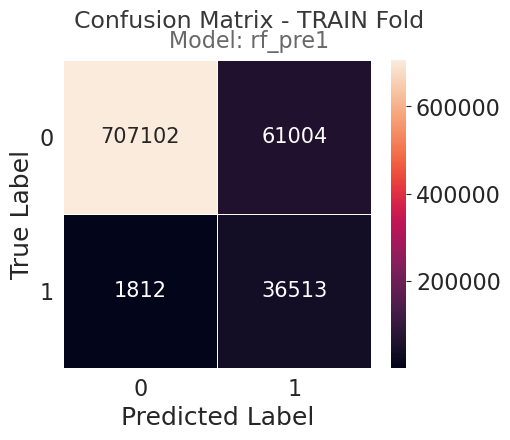

=== rf ===
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0      0.998     0.922     0.958    768106
           1      0.379     0.955     0.543     38325

    accuracy                          0.924    806431
   macro avg      0.688     0.939     0.751    806431
weighted avg      0.968     0.924     0.939    806431



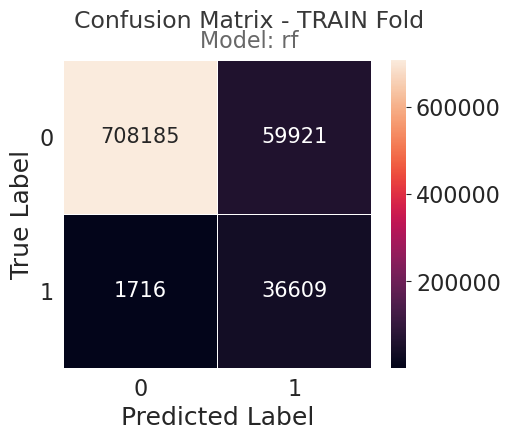

=== xgboost_pre1 ===
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=900,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
              precision    recall  f1-score   support

           0      0.991     0.764     0.863    768106
           1      0.153     0.855     0.260     38325

    accuracy                          0.768    806431
   macro avg      0.572     0.809     0.561    806431
weighted avg 

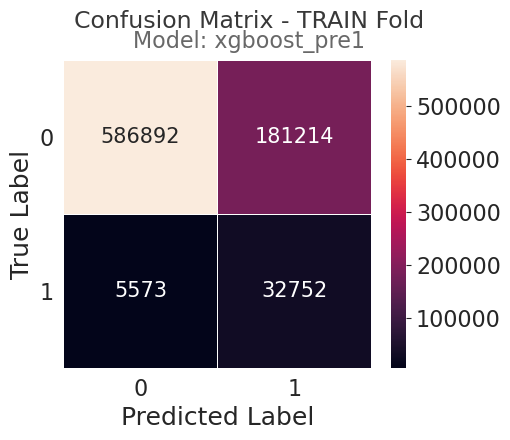

=== xgboost ===
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=2,
              missing=nan, monotone_constraints='()', n_estimators=900,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
              precision    recall  f1-score   support

           0      0.991     0.773     0.869    768106
           1      0.159     0.862     0.269     38325

    accuracy                          0.777    806431
   macro avg      0.575     0.817     0.569    806431
weighted avg     

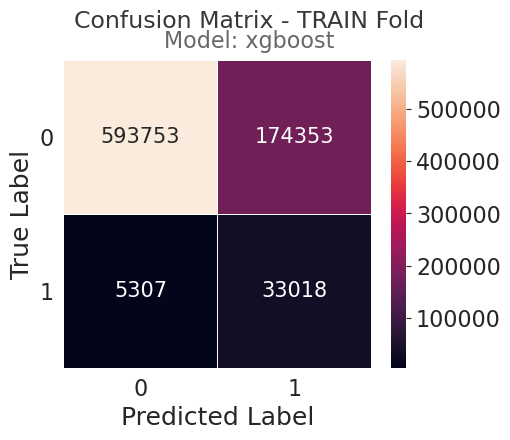

=== hgbc_pre1 ===
HistGradientBoostingClassifier(learning_rate=0.15, max_depth=5, max_iter=500,
                               random_state=42)
              precision    recall  f1-score   support

           0      0.955     0.998     0.976    768106
           1      0.628     0.063     0.115     38325

    accuracy                          0.954    806431
   macro avg      0.792     0.531     0.546    806431
weighted avg      0.940     0.954     0.935    806431



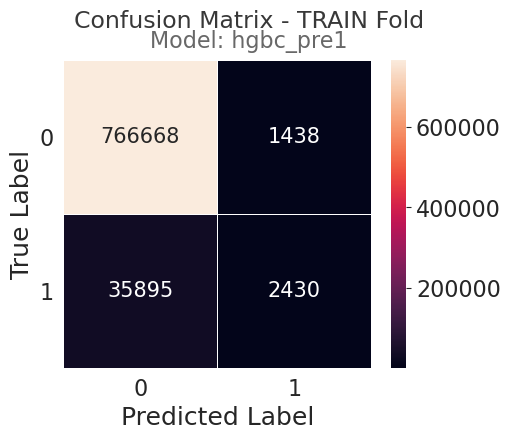

In [362]:
l_train_error = list()

for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(d_data_folds['X_train'])
    y_true_ = d_data_folds['y_train']
    print(f"=== {m_name} ===")
    print(d_gs.best_estimator_['clf'])
#     try:
    print(classification_report(y_true_, y_pred=y_pred_, digits=3))
    accuracy_ = accuracy_score(y_true_, y_pred=y_pred_)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(d_data_folds['y_test'], y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(d_data_folds['y_test'], y_pred=y_pred_)
        
    # save error dataframe
    l_train_error.append(
        {
            'model_name': m_name,
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
        }
    )
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_true_, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))

        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - TRAIN Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()

### Test evaluation


========= rf_pre1 =========
              precision    recall  f1-score   support

           0      0.974     0.911     0.941    164609
           1      0.219     0.504     0.305      8198

    accuracy                          0.891    172807
   macro avg      0.596     0.707     0.623    172807
weighted avg      0.938     0.891     0.911    172807



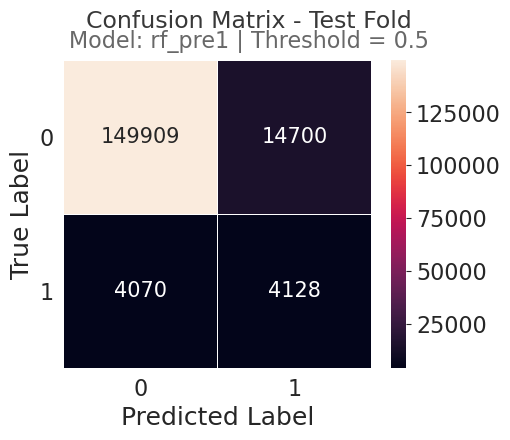

              precision    recall  f1-score   support

           0      0.996     0.469     0.638    164609
           1      0.083     0.965     0.153      8198

    accuracy                          0.493    172807
   macro avg      0.540     0.717     0.396    172807
weighted avg      0.953     0.493     0.615    172807



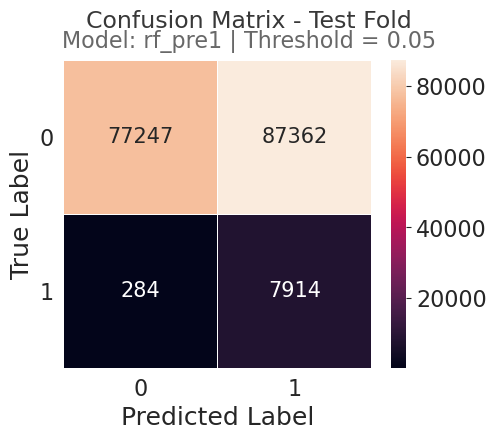

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"153,979",89.1%,89.1%
1,"18,828",10.9%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
1,"95,276",55.1%,55.1%
0,"77,531",44.9%,100.0%



========= rf =========
              precision    recall  f1-score   support

           0      0.973     0.912     0.942    164609
           1      0.220     0.499     0.306      8198

    accuracy                          0.892    172807
   macro avg      0.597     0.706     0.624    172807
weighted avg      0.938     0.892     0.911    172807



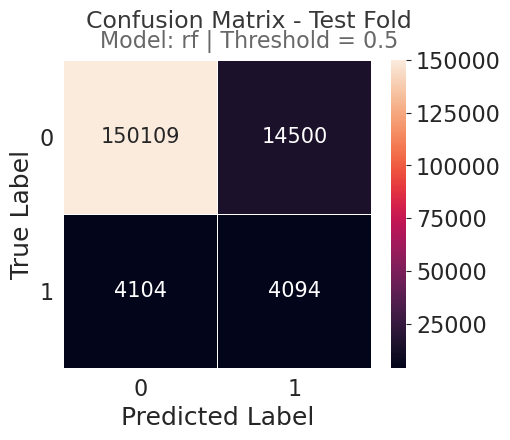

              precision    recall  f1-score   support

           0      0.996     0.473     0.642    164609
           1      0.084     0.966     0.154      8198

    accuracy                          0.496    172807
   macro avg      0.540     0.719     0.398    172807
weighted avg      0.953     0.496     0.618    172807



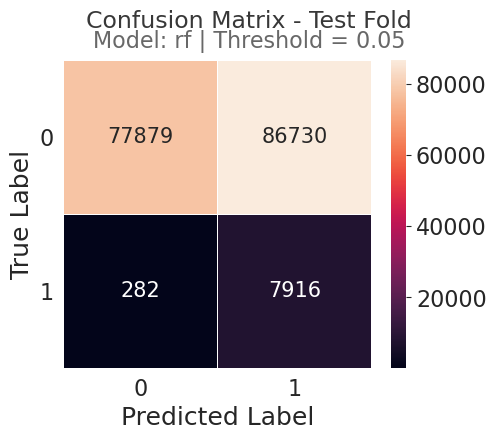

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"154,213",89.2%,89.2%
1,"18,594",10.8%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
1,"94,646",54.8%,54.8%
0,"78,161",45.2%,100.0%



========= xgboost_pre1 =========
              precision    recall  f1-score   support

           0      0.988     0.762     0.860    164609
           1      0.145     0.809     0.245      8198

    accuracy                          0.764    172807
   macro avg      0.566     0.785     0.553    172807
weighted avg      0.948     0.764     0.831    172807



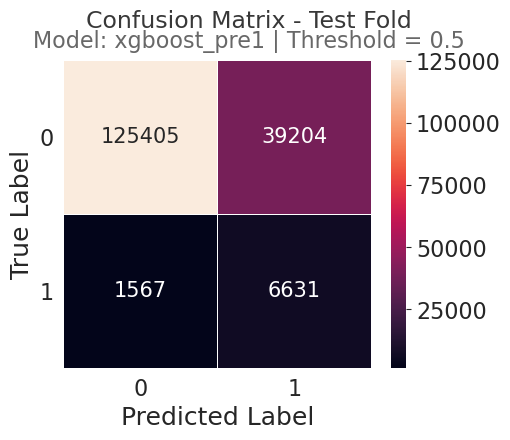

              precision    recall  f1-score   support

           0      0.998     0.254     0.405    164609
           1      0.062     0.991     0.117      8198

    accuracy                          0.289    172807
   macro avg      0.530     0.622     0.261    172807
weighted avg      0.954     0.289     0.391    172807



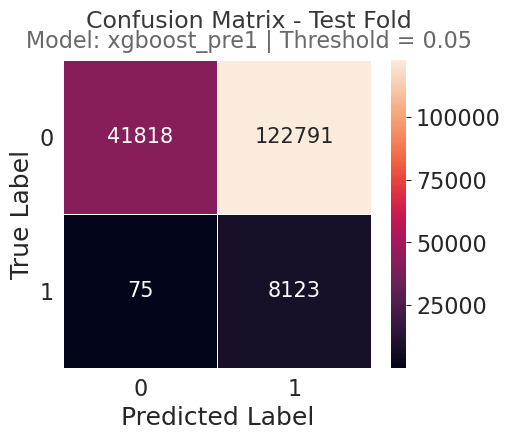

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"126,972",73.5%,73.5%
1,"45,835",26.5%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
1,"130,914",75.8%,75.8%
0,"41,893",24.2%,100.0%



========= xgboost =========
              precision    recall  f1-score   support

           0      0.987     0.770     0.865    164609
           1      0.147     0.797     0.248      8198

    accuracy                          0.771    172807
   macro avg      0.567     0.783     0.557    172807
weighted avg      0.947     0.771     0.836    172807



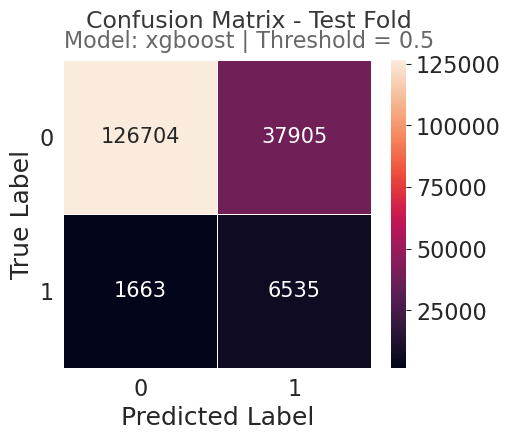

              precision    recall  f1-score   support

           0      0.998     0.263     0.416    164609
           1      0.063     0.989     0.118      8198

    accuracy                          0.297    172807
   macro avg      0.530     0.626     0.267    172807
weighted avg      0.953     0.297     0.402    172807



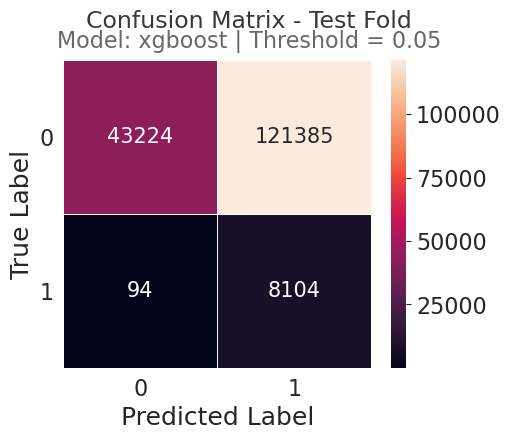

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"128,367",74.3%,74.3%
1,"44,440",25.7%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
1,"129,489",74.9%,74.9%
0,"43,318",25.1%,100.0%



========= hgbc_pre1 =========
              precision    recall  f1-score   support

           0      0.955     0.998     0.976    164609
           1      0.581     0.056     0.103      8198

    accuracy                          0.953    172807
   macro avg      0.768     0.527     0.539    172807
weighted avg      0.937     0.953     0.935    172807



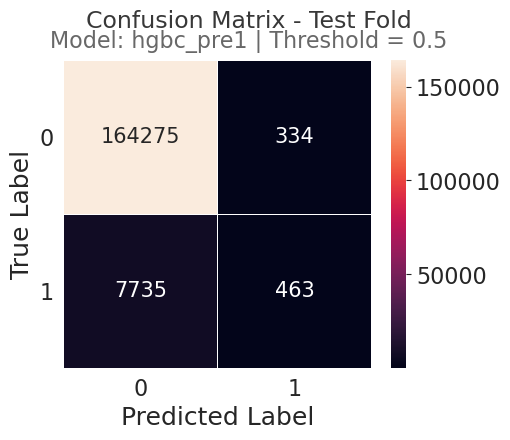

              precision    recall  f1-score   support

           0      0.988     0.754     0.856    164609
           1      0.143     0.821     0.243      8198

    accuracy                          0.757    172807
   macro avg      0.566     0.788     0.549    172807
weighted avg      0.948     0.757     0.827    172807



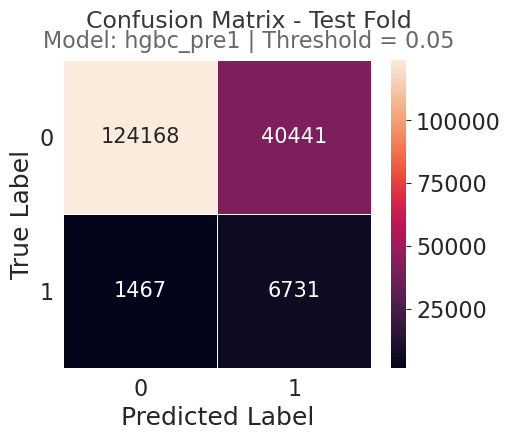

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"172,010",99.5%,99.5%
1,797,0.5%,100.0%


,pred_proba_0.05-count,pred_proba_0.05-percent,pred_proba_0.05-pct_cumulative_sum
0,"125,635",72.7%,72.7%
1,"47,172",27.3%,100.0%


In [363]:
l_test_error = list()
proba_alt_ = 0.05
for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_test)
    y_pred_a = (d_gs.predict_proba(X_test)[:,1] >= proba_alt_).astype('int')
    
    print(f"\n========= {m_name} =========")
#     try:
    print(classification_report(d_data_folds['y_test'], y_pred=y_pred_, digits=3))
    d_clf_report_ = classification_report(d_data_folds['y_test'], y_pred=y_pred_, digits=3, output_dict=True)
    d_clf_report_proba_ = classification_report(d_data_folds['y_test'], y_pred=y_pred_a, digits=3, output_dict=True)

    accuracy_ = accuracy_score(d_data_folds['y_test'], y_pred=y_pred_)
    accuracy_proba_ = accuracy_score(d_data_folds['y_test'], y_pred=y_pred_a)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(d_data_folds['y_test'], y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(d_data_folds['y_test'], y_pred=y_pred_)
        
    # save metrics dataframe for threshold=0.5
    l_test_error.append({
        **{
            'model_name': m_name,
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'proba_threshold': 0.5,
        },
        **{f"{k}_1": v for k, v in d_clf_report_['1'].items()},
        **{
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
        },
        **{f"{k}_0": v for k, v in d_clf_report_['0'].items()},
        **{f"{k}_macro_avg": v for k, v in d_clf_report_['macro avg'].items()},
        **{f"{k}_weighted_avg": v for k, v in d_clf_report_['weighted avg'].items()},
    })
    
    # save metrics dataframe for custom threshold
    l_test_error.append({
        **{
            'model_name': m_name,
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'proba_threshold': proba_alt_,
        },
        **{f"{k}_1": v for k, v in d_clf_report_proba_['1'].items()},
        **{
            'error': 1 - accuracy_proba_,
            'accuracy': accuracy_proba_,
        },
        **{f"{k}_0": v for k, v in d_clf_report_proba_['0'].items()},
        **{f"{k}_macro_avg": v for k, v in d_clf_report_proba_['macro avg'].items()},
        **{f"{k}_weighted_avg": v for k, v in d_clf_report_proba_['weighted avg'].items()},
    })
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=d_data_folds['y_test'], y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))
        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name} | Threshold = 0.5",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
        
    print(classification_report(d_data_folds['y_test'], y_pred=y_pred_a, digits=3))
    conf_mx = confusion_matrix(y_true=d_data_folds['y_test'], y_pred=y_pred_a, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))
        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name} | Threshold = {proba_alt_}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
    
    # prediction at 0.5
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_, name='pred').to_frame(),
            'pred',
        ).set_caption(f"Default threshold")
    )
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_a, name=f'pred_proba_{proba_alt_}').to_frame(),
            f'pred_proba_{proba_alt_}',
        ).set_caption(f"Custom threshold: {proba_alt_}")
    )


========= rf_pre1 =========
              precision    recall  f1-score   support

           0      0.998     0.286     0.444    164609
           1      0.064     0.988     0.121      8198

    accuracy                          0.319    172807
   macro avg      0.531     0.637     0.283    172807
weighted avg      0.954     0.319     0.429    172807



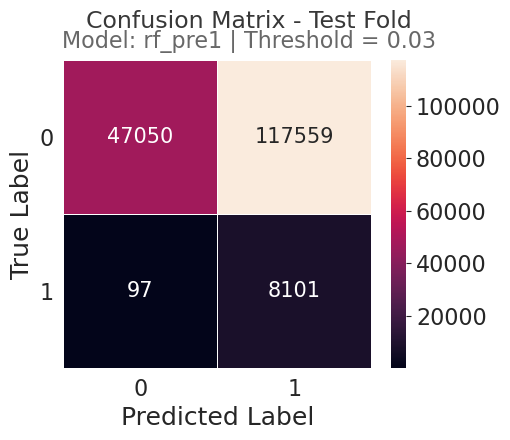

,pred_proba_0.025-count,pred_proba_0.025-percent,pred_proba_0.025-pct_cumulative_sum
1,"125,660",72.7%,72.7%
0,"47,147",27.3%,100.0%



========= xgboost_pre1 =========
              precision    recall  f1-score   support

           0      0.999     0.051     0.096    164609
           1      0.050     0.999     0.095      8198

    accuracy                          0.096    172807
   macro avg      0.524     0.525     0.096    172807
weighted avg      0.954     0.096     0.096    172807



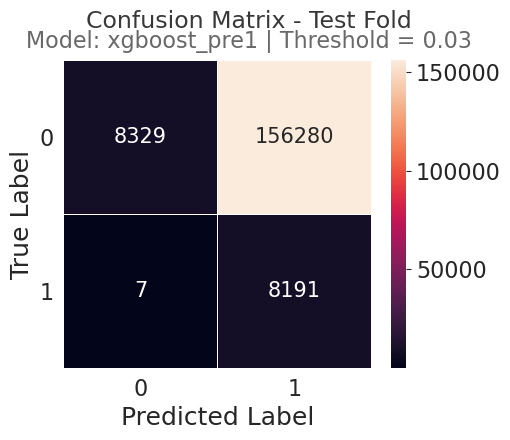

,pred_proba_0.025-count,pred_proba_0.025-percent,pred_proba_0.025-pct_cumulative_sum
1,"164,471",95.2%,95.2%
0,"8,336",4.8%,100.0%


In [364]:
# l_test_error = list()
proba_alt_ = 0.025

for m_name, d_gs in d_search_fit.items():
    if m_name not in ['xgboost_pre1', 'rf_pre1']:
        continue
    y_pred_a = (d_gs.predict_proba(X_test)[:,1] >= proba_alt_).astype('int')
    
    print(f"\n========= {m_name} =========")
    d_clf_report_proba_ = classification_report(d_data_folds['y_test'], y_pred=y_pred_a, digits=3, output_dict=True)

    accuracy_proba_ = accuracy_score(d_data_folds['y_test'], y_pred=y_pred_a)
    
    # save metrics dataframe for custom threshold
    l_test_error.append({
        **{
            'model_name': m_name,
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'proba_threshold': proba_alt_,
        },
        **{f"{k}_1": v for k, v in d_clf_report_proba_['1'].items()},
        **{
            'error': 1 - accuracy_proba_,
            'accuracy': accuracy_proba_,
        },
        **{f"{k}_0": v for k, v in d_clf_report_proba_['0'].items()},
        **{f"{k}_macro_avg": v for k, v in d_clf_report_proba_['macro avg'].items()},
        **{f"{k}_weighted_avg": v for k, v in d_clf_report_proba_['weighted avg'].items()},
    })
        
    print(classification_report(y_test, y_pred=y_pred_a, digits=3))
    conf_mx = confusion_matrix(y_true=y_test, y_pred=y_pred_a, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))
        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name} | Threshold = {proba_alt_:,.2f}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
    
    # Prediction at custom threshold
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_a, name=f'pred_proba_{proba_alt_}').to_frame(),
            f'pred_proba_{proba_alt_}',
        ).set_caption(f"Custom threshold: {proba_alt_}")
    )

## Plot table of errors by model type

In [365]:
# CTR for users that the model picks would be:
false_pred_clicks_ = 16682
true_pred_clicks_ = 2382
total_selected = (false_pred_clicks_ + true_pred_clicks_)

pct_selected_to_send = total_selected / len(X_test)
total_projected_send = len(df_train) * pct_selected_to_send
print(f"Total sends (test): {total_selected:,.0f}")
print(f"Sends as Percent of actual: {pct_selected_to_send:,.2%}")
print(f"Total Receives: {len(df_train):,.0f}")
print(f"Total Sends Projected: {total_projected_send:,.0f}")

print(f"New CTR: {true_pred_clicks_ / total_selected:,.2%}")

Total sends (test): 19,064
Sends as Percent of actual: 11.03%
Total Receives: 1,152,045
Total Sends Projected: 127,093
New CTR: 12.49%


In [366]:
# original CTR
value_counts_and_pcts(
    df_train,
    ['click'],
    sort_index=True,
    top_n=None,
)

,count,percent,cumulative_percent
click,,,
1,"54,727",4.8%,4.8%
0,"1,097,318",95.2%,100.0%


In [367]:
df_error_test = (
    pd.DataFrame(l_test_error)
    .sort_values(by=['recall_1'], ascending=False,)
)
df_error_test['model_params'] = (
    df_error_test['model_params']
    .str.replace('[\w]{2,25}=None,', '', regex=True)
    .str.replace('[\w]{2,25}=-?[01],', '', regex=True)
    .str.replace("[\w]{2,25}='auto',", '', regex=True)
    .str.replace("[\w]{2,25}=nan,", '', regex=True)
    .str.replace("[\w]{2,25}='',", '', regex=True)
    .str.replace("[\w]{2,35}='()',", '', regex=True)
)

display(
    style_df_numeric(
        df_error_test
        .drop(
            [_ for _ in df_error_test.columns if any([_.endswith(v_) for v_ in ['_0', '_avg']])],
            axis=1,
        ),
        float_round=3,
        l_bar_simple=['precision_1', 'recall_1', 'f1-score_1', 'error'],
    ).set_caption(f"<h3 align='left'>Holdout/Test Results</h2>")
)

style_df_numeric(
    df_error_test.drop(['model_params'], axis=1),
    float_round=3,
    l_bar_simple=['precision_1', 'recall_1', 'f1-score_1', 'error'],
).set_caption(f"<h3 align='left'>Holdout/Test Results</h2>")


,model_name,model_params,model_class,proba_threshold,precision_1,recall_1,f1-score_1,support_1,error,accuracy
11,xgboost_pre1,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.1, max_bin=256, max_cat_to_onehot=4, max_depth=4, min_child_weight=2, monotone_constraints='()', n_estimators=900, random_state=42, ...)",XGBClassifier,0.025,0.050,0.999,0.095,"8,198",0.904,0.096
5,xgboost_pre1,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.1, max_bin=256, max_cat_to_onehot=4, max_depth=4, min_child_weight=2, monotone_constraints='()', n_estimators=900, random_state=42, ...)",XGBClassifier,0.050,0.062,0.991,0.117,"8,198",0.711,0.289
7,xgboost,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.15, max_bin=256, max_cat_to_onehot=4, max_depth=4, min_child_weight=2, monotone_constraints='()', n_estimators=900, random_state=42, ...)",XGBClassifier,0.050,0.063,0.989,0.118,"8,198",0.703,0.297
10,rf_pre1,"RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=2, n_estimators=800, random_state=42)",RandomForestClassifier,0.025,0.064,0.988,0.121,"8,198",0.681,0.319
3,rf,"RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=2, n_estimators=800, random_state=42)",RandomForestClassifier,0.050,0.084,0.966,0.154,"8,198",0.504,0.496
1,rf_pre1,"RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=2, n_estimators=800, random_state=42)",RandomForestClassifier,0.050,0.083,0.965,0.153,"8,198",0.507,0.493
9,hgbc_pre1,"HistGradientBoostingClassifier(learning_rate=0.15, max_depth=5, max_iter=500, random_state=42)",HistGradientBoostingClassifier,0.050,0.143,0.821,0.243,"8,198",0.243,0.757
4,xgboost_pre1,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.1, max_bin=256, max_cat_to_onehot=4, max_depth=4, min_child_weight=2, monotone_constraints='()', n_estimators=900, random_state=42, ...)",XGBClassifier,0.500,0.145,0.809,0.245,"8,198",0.236,0.764
6,xgboost,"XGBClassifier(base_score=0.5, booster='gbtree', enable_categorical=False, eval_metric='auc', grow_policy='depthwise', learning_rate=0.15, max_bin=256, max_cat_to_onehot=4, max_depth=4, min_child_weight=2, monotone_constraints='()', n_estimators=900, random_state=42, ...)",XGBClassifier,0.500,0.147,0.797,0.248,"8,198",0.229,0.771
0,rf_pre1,"RandomForestClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=2, n_estimators=800, random_state=42)",RandomForestClassifier,0.500,0.219,0.504,0.305,"8,198",0.109,0.891


,model_name,model_class,proba_threshold,precision_1,recall_1,f1-score_1,support_1,error,accuracy,precision_0,recall_0,f1-score_0,support_0,precision_macro_avg,recall_macro_avg,f1-score_macro_avg,support_macro_avg,precision_weighted_avg,recall_weighted_avg,f1-score_weighted_avg,support_weighted_avg
11,xgboost_pre1,XGBClassifier,0.025,0.050,0.999,0.095,"8,198",0.904,0.096,0.999,0.051,0.096,"164,609",0.524,0.525,0.096,"172,807",0.954,0.096,0.096,"172,807"
5,xgboost_pre1,XGBClassifier,0.050,0.062,0.991,0.117,"8,198",0.711,0.289,0.998,0.254,0.405,"164,609",0.530,0.622,0.261,"172,807",0.954,0.289,0.391,"172,807"
7,xgboost,XGBClassifier,0.050,0.063,0.989,0.118,"8,198",0.703,0.297,0.998,0.263,0.416,"164,609",0.530,0.626,0.267,"172,807",0.953,0.297,0.402,"172,807"
10,rf_pre1,RandomForestClassifier,0.025,0.064,0.988,0.121,"8,198",0.681,0.319,0.998,0.286,0.444,"164,609",0.531,0.637,0.283,"172,807",0.954,0.319,0.429,"172,807"
3,rf,RandomForestClassifier,0.050,0.084,0.966,0.154,"8,198",0.504,0.496,0.996,0.473,0.642,"164,609",0.540,0.719,0.398,"172,807",0.953,0.496,0.618,"172,807"
1,rf_pre1,RandomForestClassifier,0.050,0.083,0.965,0.153,"8,198",0.507,0.493,0.996,0.469,0.638,"164,609",0.540,0.717,0.396,"172,807",0.953,0.493,0.615,"172,807"
9,hgbc_pre1,HistGradientBoostingClassifier,0.050,0.143,0.821,0.243,"8,198",0.243,0.757,0.988,0.754,0.856,"164,609",0.566,0.788,0.549,"172,807",0.948,0.757,0.827,"172,807"
4,xgboost_pre1,XGBClassifier,0.500,0.145,0.809,0.245,"8,198",0.236,0.764,0.988,0.762,0.860,"164,609",0.566,0.785,0.553,"172,807",0.948,0.764,0.831,"172,807"
6,xgboost,XGBClassifier,0.500,0.147,0.797,0.248,"8,198",0.229,0.771,0.987,0.770,0.865,"164,609",0.567,0.783,0.557,"172,807",0.947,0.771,0.836,"172,807"
0,rf_pre1,RandomForestClassifier,0.500,0.219,0.504,0.305,"8,198",0.109,0.891,0.974,0.911,0.941,"164,609",0.596,0.707,0.623,"172,807",0.938,0.891,0.911,"172,807"


In [368]:
try:
    print(d_search_fit['xgboost_pre1'].best_params_)
    print(d_search_fit['xgboost_pre1'].best_estimator_['clf'].get_xgb_params())
except Exception as e:
    pass

{'clf__eval_metric': 'auc', 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__min_child_weight': 2, 'clf__n_estimators': 900, 'preprocess__scale': RobustScaler()}
{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eval_metric': 'auc', 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'interaction_constraints': '', 'learning_rate': 0.1, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 4, 'max_leaves': 0, 'min_child_weight': 2, 'monotone_constraints': '()', 'n_jobs': -1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 20.04190476190476, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [369]:
try:
    for p_ in d_search_fit['xgboost_pre1'].best_estimator_:
        print(p_)
except Exeption as e:
    pass

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', RobustScaler(),
                                 ['screen_view_count_14d_log',
                                  'user_receives_pn_subreddit_count_t7',
                                  'user_receives_pn_t7', 'user_receives_pn_t14',
                                  'user_receives_pn_t30',
                                  'log_user_clicks_pn_t7',
                                  'log_user_clicks_trnd_t7',
                                  'log_post_consumes_30',
                                  'log_num_post_consumes_home_30',
                                  'pct_post_consumes_home_30',
                                  'p...
                                  'num_post_consumes_android_30',
                                  'sub_dau_perc_l28', 'perc_by_country_sd',
                                  'us_screenviews_l14_log',
                                  'us_distinct_posts_viewed_l14_log',
    

# Get feature importance
Might help us better select which columns to use for additional stratification

## Impurity & Gain based importance
Note that these may not be the best approach when we have features with high cardinality

In [370]:
from xgboost import plot_importance

In [371]:
# d_search_fit['xgboost'].best_estimator_['clf'].get_booster().get_score(importance_type='weight').values()


=== rf_pre1 ====


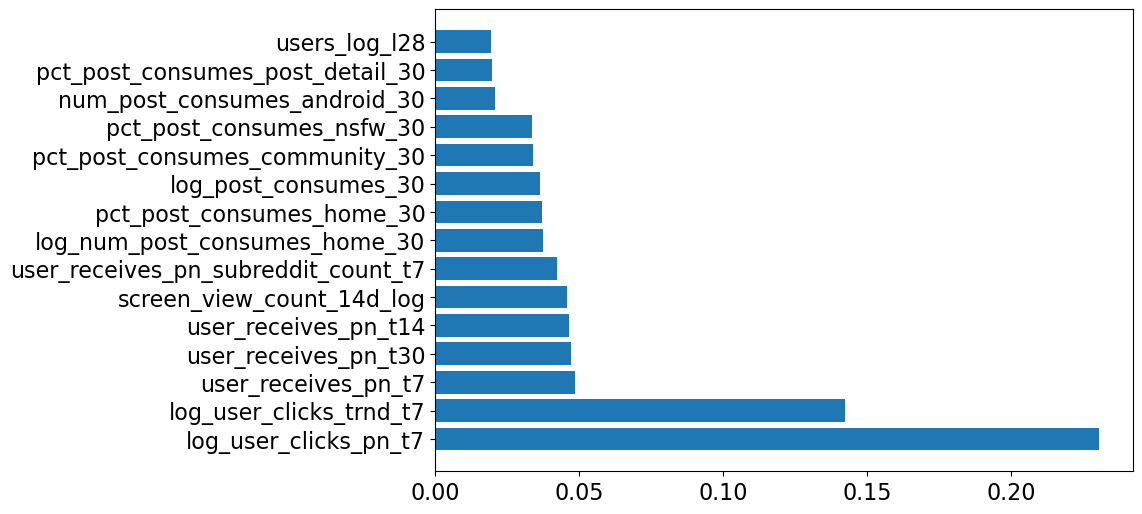

,feature_names,importances,std
5,log_user_clicks_pn_t7,0.230568,0.102775
6,log_user_clicks_trnd_t7,0.142295,0.094535
2,user_receives_pn_t7,0.048511,0.020003
4,user_receives_pn_t30,0.047286,0.017048
3,user_receives_pn_t14,0.046490,0.018768
0,screen_view_count_14d_log,0.045793,0.038715
1,user_receives_pn_subreddit_count_t7,0.042314,0.019479
8,log_num_post_consumes_home_30,0.037579,0.014880
9,pct_post_consumes_home_30,0.037041,0.009831
7,log_post_consumes_30,0.036258,0.011665


(40, 3)

=== rf ====


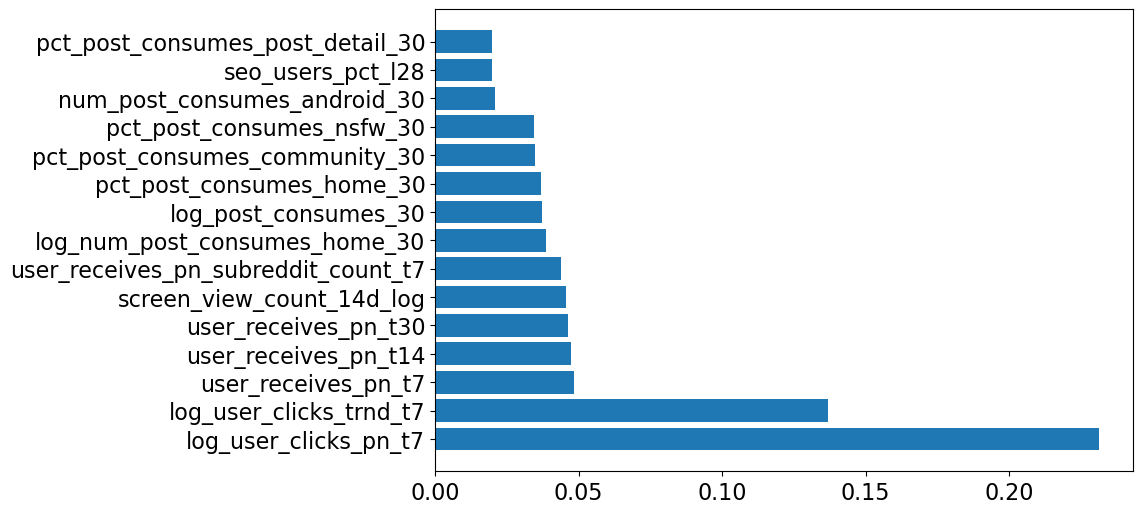

,feature_names,importances,std
7,log_user_clicks_pn_t7,0.231496,0.098092
8,log_user_clicks_trnd_t7,0.136959,0.088210
4,user_receives_pn_t7,0.048496,0.019130
5,user_receives_pn_t14,0.047244,0.018262
6,user_receives_pn_t30,0.046263,0.015775
2,screen_view_count_14d_log,0.045496,0.038029
3,user_receives_pn_subreddit_count_t7,0.043813,0.019824
10,log_num_post_consumes_home_30,0.038548,0.015965
9,log_post_consumes_30,0.037427,0.012301
11,pct_post_consumes_home_30,0.036883,0.009103


(40, 3)

=== xgboost_pre1 ====


,feature_names,importances_gain,importances_total_gain,importances_cover,importances_total_cover
5,log_user_clicks_pn_t7,"3,240.62","2,705,919.50","59,358.70","49,564,516.00"
2,user_receives_pn_t7,"1,043.62","565,643.81","75,874.36","41,123,904.00"
34,seo_users_pct_l28,679.82,"157,037.58","37,944.95","8,765,282.00"
33,users_log_l28,512.48,"176,806.81","48,166.70","16,617,513.00"
6,log_user_clicks_trnd_t7,279.20,"113,914.71","42,328.77","17,270,138.00"
1,user_receives_pn_subreddit_count_t7,256.15,"114,499.34","67,850.45","30,329,154.00"
35,loggedin_users_pct_l28,191.00,"25,403.55","46,617.31","6,200,102.50"
32,us_days_active_l30,188.11,"14,860.88","53,235.51","4,205,605.50"
11,pct_post_consumes_post_detail_30,101.63,"53,353.86","67,673.52","35,528,600.00"
36,ios_users_pct_l28,97.86,"12,722.44","25,677.75","3,338,107.75"


(40, 5)


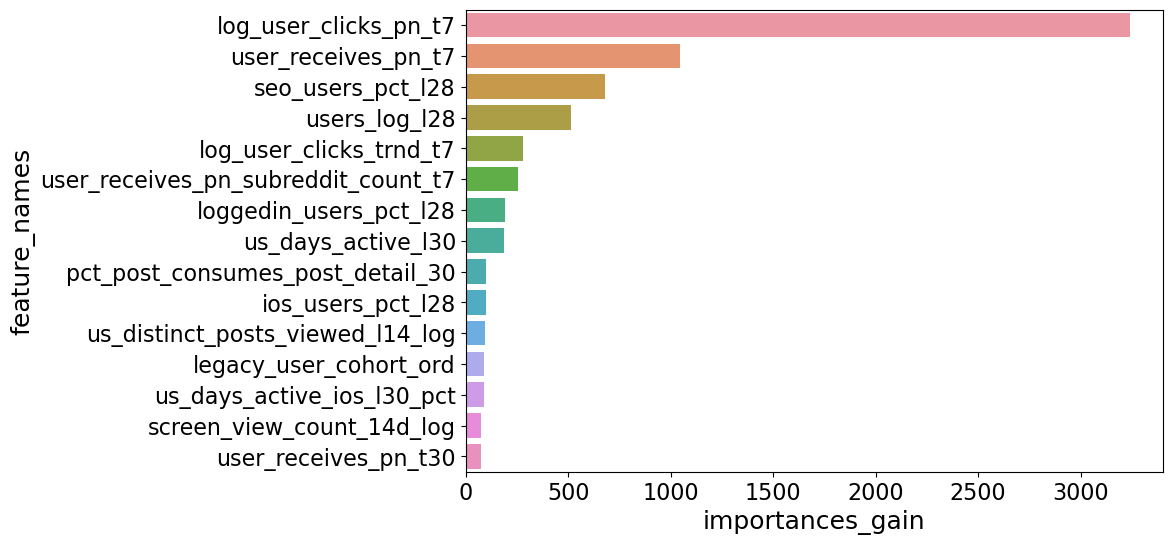


=== xgboost ====


,feature_names,importances_gain,importances_total_gain,importances_cover,importances_total_cover
7,log_user_clicks_pn_t7,"2,333.01","1,868,745.00","57,163.48","45,787,952.00"
4,user_receives_pn_t7,754.39,"387,003.22","76,311.66","39,147,884.00"
36,seo_users_pct_l28,574.60,"112,047.50","29,470.19","5,746,686.50"
35,users_log_l28,385.38,"123,322.94","39,083.72","12,506,790.00"
3,user_receives_pn_subreddit_count_t7,199.12,"79,450.40","65,124.05","25,984,494.00"
8,log_user_clicks_trnd_t7,196.94,"77,592.89","44,190.26","17,410,962.00"
34,us_days_active_l30,181.64,"14,167.92","47,718.36","3,722,032.25"
37,loggedin_users_pct_l28,131.51,"16,833.56","30,809.24","3,943,583.25"
13,pct_post_consumes_post_detail_30,83.41,"42,123.28","66,474.22","33,569,480.00"
38,ios_users_pct_l28,81.38,"9,276.81","21,711.73","2,475,137.75"


(40, 5)


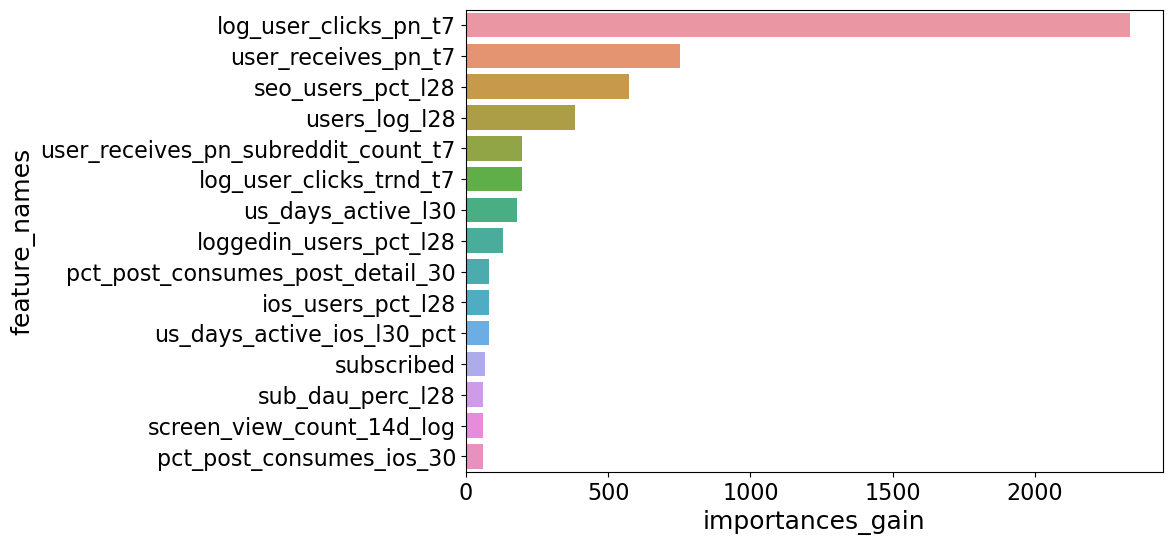


=== hgbc_pre1 ====


In [372]:
d_df_importances = dict()

for m_name, d_gs in d_search_fit.items():
    print(f"\n=== {m_name} ====")
    # try to get feature names from pipeline, otherwise from X_train
    try:
        ftr_names_ = d_gs.best_estimator_['preprocess'].get_feature_names_out()
        # sometimes there are doudlle underscores if we used an encoder like: OneHotEncoder
        ftr_names_ = [
            '__'.join(_.split('__')[1:]) if '__' in _ else _ for _ in ftr_names_
        ]
    except KeyError:
        ftr_names_ = list(d_data_folds['X_train'].columns)
        
    if type(d_gs.best_estimator_['clf']) in [RandomForestClassifier,]:
        df_importances = (
            pd.DataFrame(
                {
                    'feature_names': ftr_names_,
                    'importances': d_gs.best_estimator_['clf'].feature_importances_,
                    'std': np.std([tree.feature_importances_ for tree in d_gs.best_estimator_['clf'].estimators_], axis=0),
                }
            )
            .sort_values(by=['importances'], ascending=False)
        )
        plt.barh(
            y=df_importances.head(15)['feature_names'],
            width=df_importances.head(15)['importances'],
            # xerr=df_importances.head(15)['std'],
        )
        plt.show()
        display(
            df_importances.head(15)
        )
        print(df_importances.shape)

    elif type(d_gs.best_estimator_['clf']) in [XGBClassifier]:
        # XGBoost: We don't trust the default value b/c it weights by split
        # plot_importance(d_gs.best_estimator_['clf'])
        plt.show()
        # we need to replace the values because XGBoost will not return features if the importance is zero (no splits)
        
        d_feat_to_name = {
            f"f{i}": v for i, v in enumerate(ftr_names_)
        }
        df_importances = pd.DataFrame({'feature_names': ftr_names_})
        l_imp_cols = list()
        for imp_typ_ in ['gain', 'total_gain', 'cover', 'total_cover']:
            c_imp_typ_ = f'importances_{imp_typ_}'
            l_imp_cols.append(c_imp_typ_)
            
            df_importances = df_importances.merge(
                pd.DataFrame(
                    {
                        c_imp_typ_: d_gs.best_estimator_['clf'].get_booster().get_score(importance_type=imp_typ_).values(),
                    },
                    index=[d_feat_to_name.get(k, k) for k in d_gs.best_estimator_['clf'].get_booster().get_score(importance_type='weight').keys()]
                ),
                how='outer',
                left_on=['feature_names'],
                right_index=True,
            )
        df_importances = df_importances.sort_values(l_imp_cols[0], ascending=False)
        display(
            style_df_numeric(
                df_importances.head(20),
                l_bar_simple=l_imp_cols,
            )
        )
        print(df_importances.shape)
        try:
            ax = sns.barplot(
                data=df_importances.head(15),
                x='importances_gain',
                y='feature_names',
            )
            plt.show()
        except Exception as e:
            pass
        
    d_df_importances[m_name] = df_importances
    

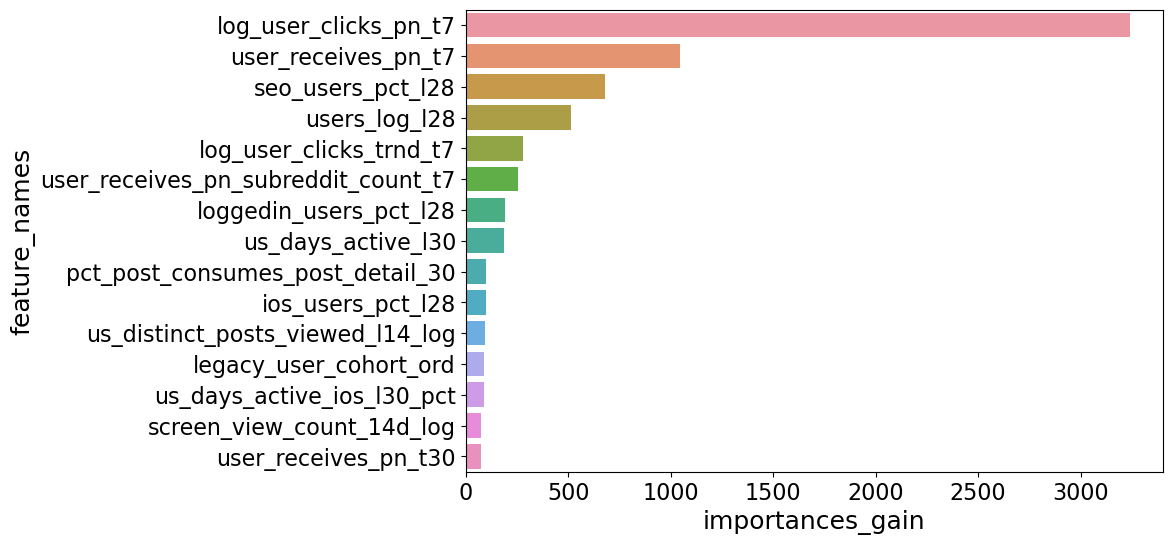

In [373]:
ax = sns.barplot(
    data=d_df_importances['xgboost_pre1'].head(15),
    x='importances_gain',
    y='feature_names',
)

In [374]:

# plt.barh(
#     y=df_importances.head(15)['feature_names'],
#     width=df_importances.head(15)['importances'],
#     xerr=df_importances.head(15)['std'],
# )

# Check proba outputs


=== rf_pre1 ===


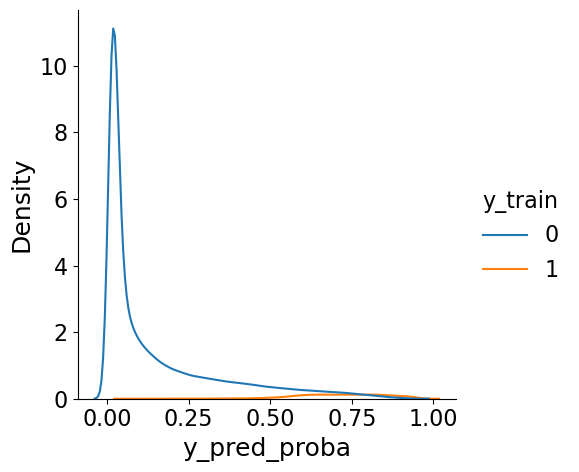

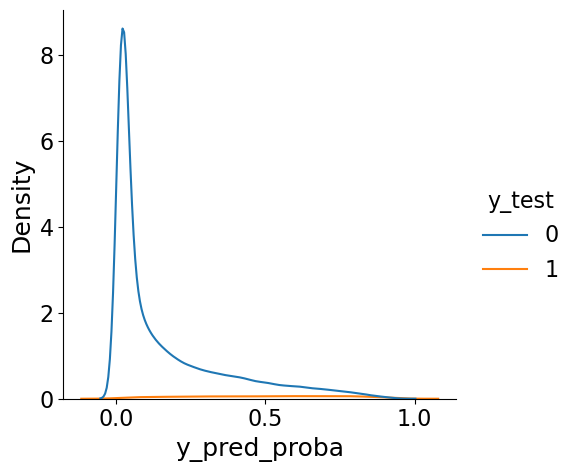


=== rf ===


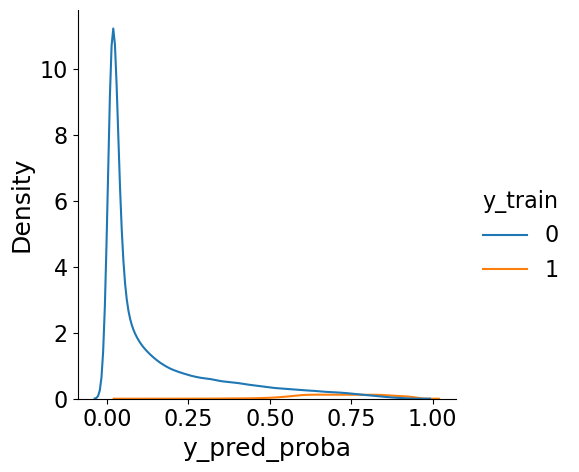

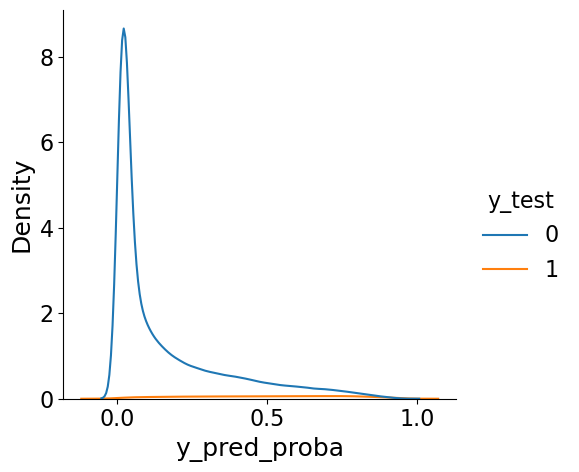


=== xgboost_pre1 ===


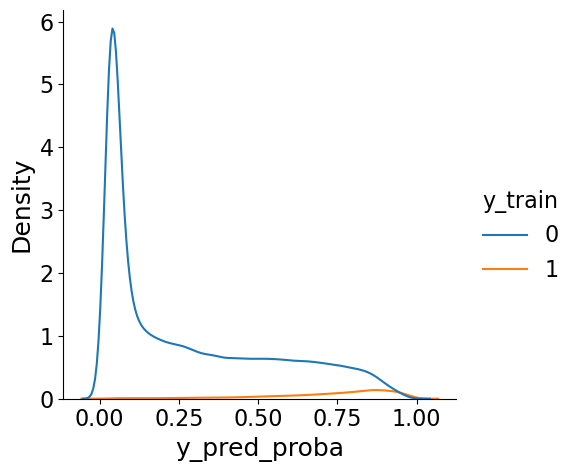

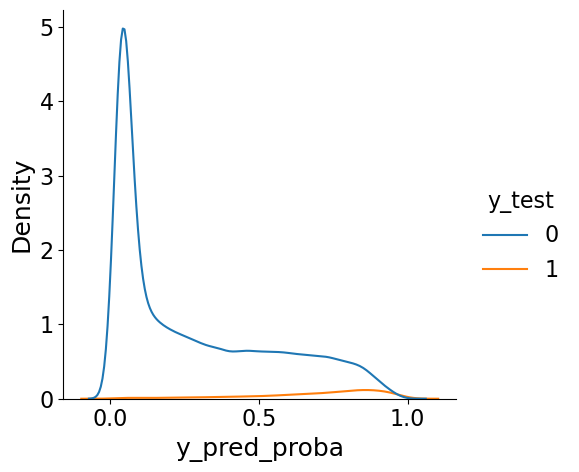


=== xgboost ===


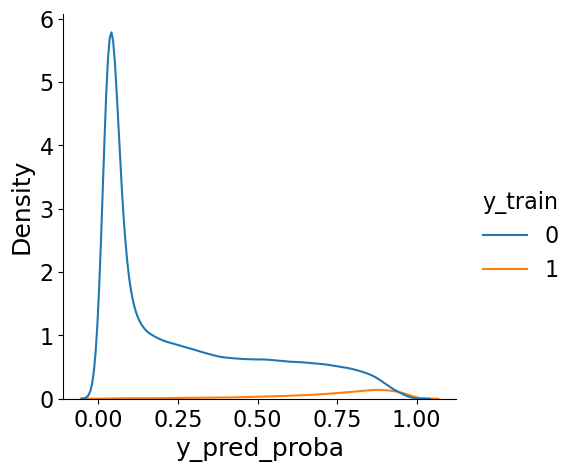

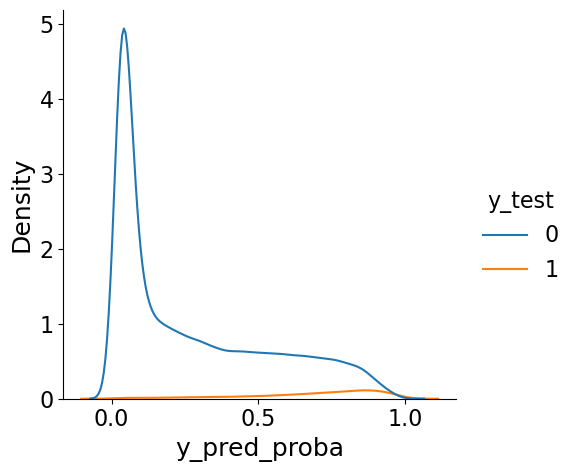


=== hgbc_pre1 ===


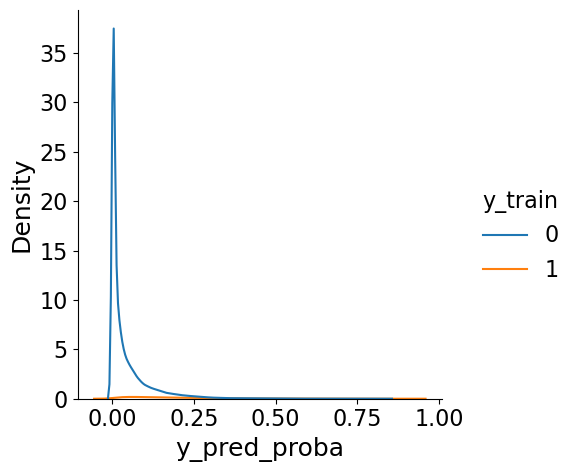

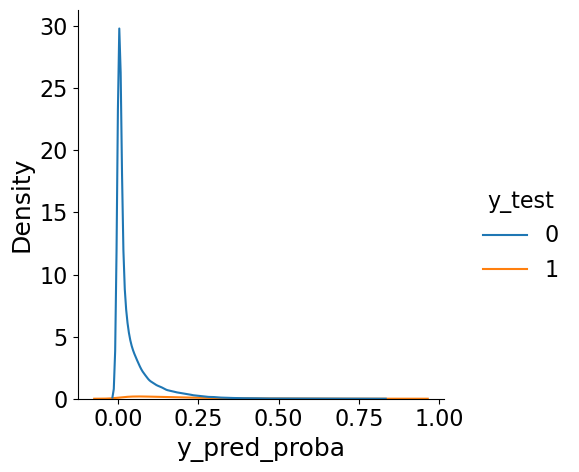

In [375]:
for m_name, d_gs in d_search_fit.items():
    print(f"\n=== {m_name} ===")
    df_y_test_ = pd.DataFrame(
        {
            'y_test': y_test,
            'y_pred_proba': d_gs.predict_proba(X_test)[:, 1],
        }
    )
    df_y_train_ = pd.DataFrame(
        {
            'y_train': d_data_folds['y_train'],
            'y_pred_proba': d_gs.predict_proba(d_data_folds['X_train'])[:, 1],
        }
    )
    sns.displot(data=df_y_train_, x="y_pred_proba", kind='kde', hue='y_train')
    plt.show()
    
    sns.displot(data=df_y_test_, x="y_pred_proba", kind='kde', hue='y_test')
    plt.show()

In [376]:
(
    df_y_test_
    .sort_values(['y_pred_proba'], ascending=False)
).head(20)

,y_test,y_pred_proba
34533,1,0.888880
21099,1,0.847133
50945,1,0.833503
38469,1,0.831172
20583,1,0.816104
611495,0,0.815259
128688,0,0.813959
29471,1,0.813090
24629,1,0.797973
402037,0,0.794081


In [377]:
(
    df_y_test_
    [df_y_test_['y_test'] == 1]
    .sort_values(['y_pred_proba'], ascending=False)
).tail(20)

,y_test,y_pred_proba
28382,1,0.002093
51683,1,0.002092
3965,1,0.002089
23763,1,0.002076
49019,1,0.002057
53229,1,0.002023
53279,1,0.002009
37834,1,0.001966
43843,1,0.001959
50686,1,0.001907


# EDA - feature correlation for feature selection
It's possible some features are adding noise & hurting model performance, so let's check them out & exclude those with low gain and high correlation to features that are already important

In [378]:
from matplotlib import cm

In [379]:
try:
    print(d_df_importances['xgboost_pre1'].shape)
    print(d_df_importances['xgboost_pre1']['feature_names'].to_list())
    #  Only show the most important features
    l_cols_train_ordered = d_df_importances['xgboost_pre1']['feature_names'].to_list()[:15][::-1]
    print(l_cols_train_ordered)
except Exception as e:
    pass

(40, 5)
['log_user_clicks_pn_t7', 'user_receives_pn_t7', 'seo_users_pct_l28', 'users_log_l28', 'log_user_clicks_trnd_t7', 'user_receives_pn_subreddit_count_t7', 'loggedin_users_pct_l28', 'us_days_active_l30', 'pct_post_consumes_post_detail_30', 'ios_users_pct_l28', 'us_distinct_posts_viewed_l14_log', 'legacy_user_cohort_ord', 'us_days_active_ios_l30_pct', 'screen_view_count_14d_log', 'user_receives_pn_t30', 'android_users_pct_l28', 'perc_by_country_sd', 'pct_post_consumes_ios_30', 'num_post_consumes_ios_30', 'pct_post_consumes_home_30', 'num_post_consumes_android_30', 'subscribed', 'pct_post_consumes_nsfw_30', 'log_num_post_consumes_home_30', 'log_post_consumes_30', 'us_upvotes_l14', 'us_ios_days_active_l30', 'pct_post_consumes_android_30', 'us_post_screenviews_l14_log', 'user_receives_pn_t14', 'sub_dau_perc_l28', 'pct_post_consumes_community_30', 'us_screenviews_l14_log', 'us_android_days_active_l30', 'us_sessions_l14', 'us_trend_pn_receive_l14_log', 'us_trend_pn_click_l14', 'us_andro

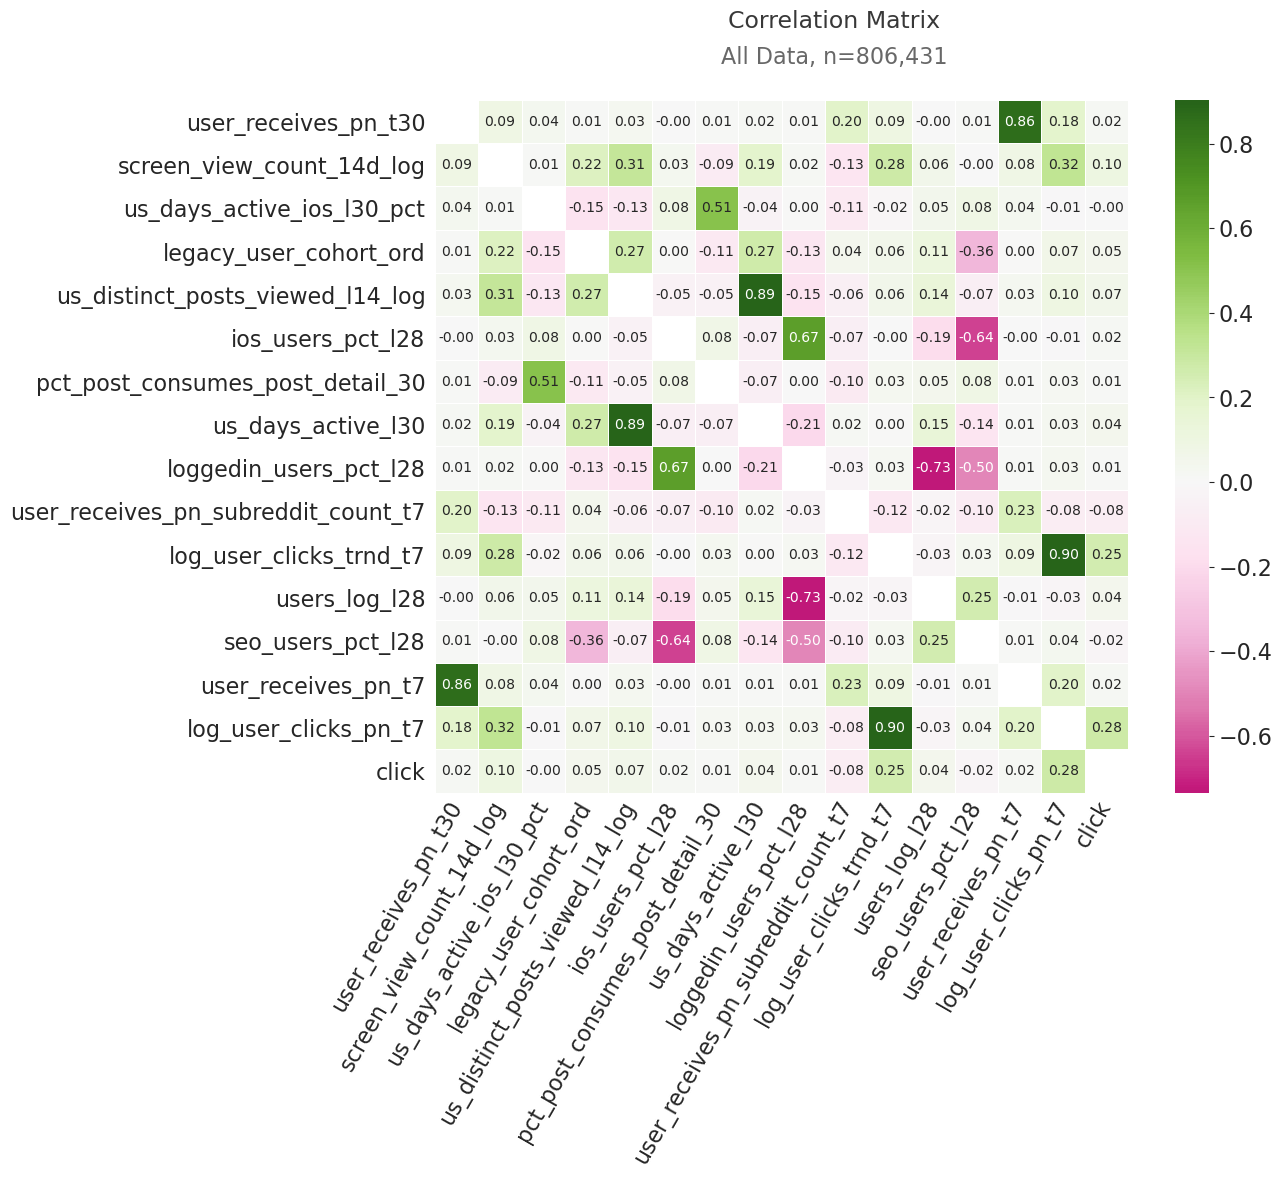

In [380]:
# Use this one that only keeps items below diagonal
#   it's also centered on zero so it's less skewed
plt.figure(figsize=(12, 9))
mask_type = 'diag'  # 'triangle' or 'diag'

try:
    # Create final corrmat sorted by most correlated to feature importance
    #.  pull feature imporance from above step(s)
    #. show in reverse importance so that we see most important features at bottom (long) & it's easier to read correlation cols
    corrmat = (
        pd.concat(
            [d_data_folds['X_train'][l_cols_train_ordered], d_data_folds['y_train']],
            axis=1,
        )
        .corr()
    )
    mask = np.zeros_like(corrmat)
    if mask_type == 'triangle':
        # For triangle:
        mask[np.triu_indices_from(mask)] = True
    elif mask_type == 'diag':
        # Exclude only the diagonal:
        np.fill_diagonal(mask, 1.0)

    with sns.axes_style("white"):
        sns.heatmap(
            corrmat, center=0,
            cmap=cm.PiYG,
            mask=mask,
            annot=True,
            annot_kws={"size": 10},
            square=True,
            fmt="0.2f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        plt.xticks(rotation=60, va='center', ha='right', rotation_mode='anchor')

        plt.figtext(
            .5, .96, f"Correlation Matrix",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .92, f"All Data, n={len(d_data_folds['X_train']):,.0f}",
            fontsize=16, color='#686868', ha='center'
        )
    plt.show()
except Exception as e:
    pass

Cols to exclude:
['num_post_consumes_nsfw', 'view_and_consume_unique_count', 'view_count', 'num_post_consumes_post_detail']


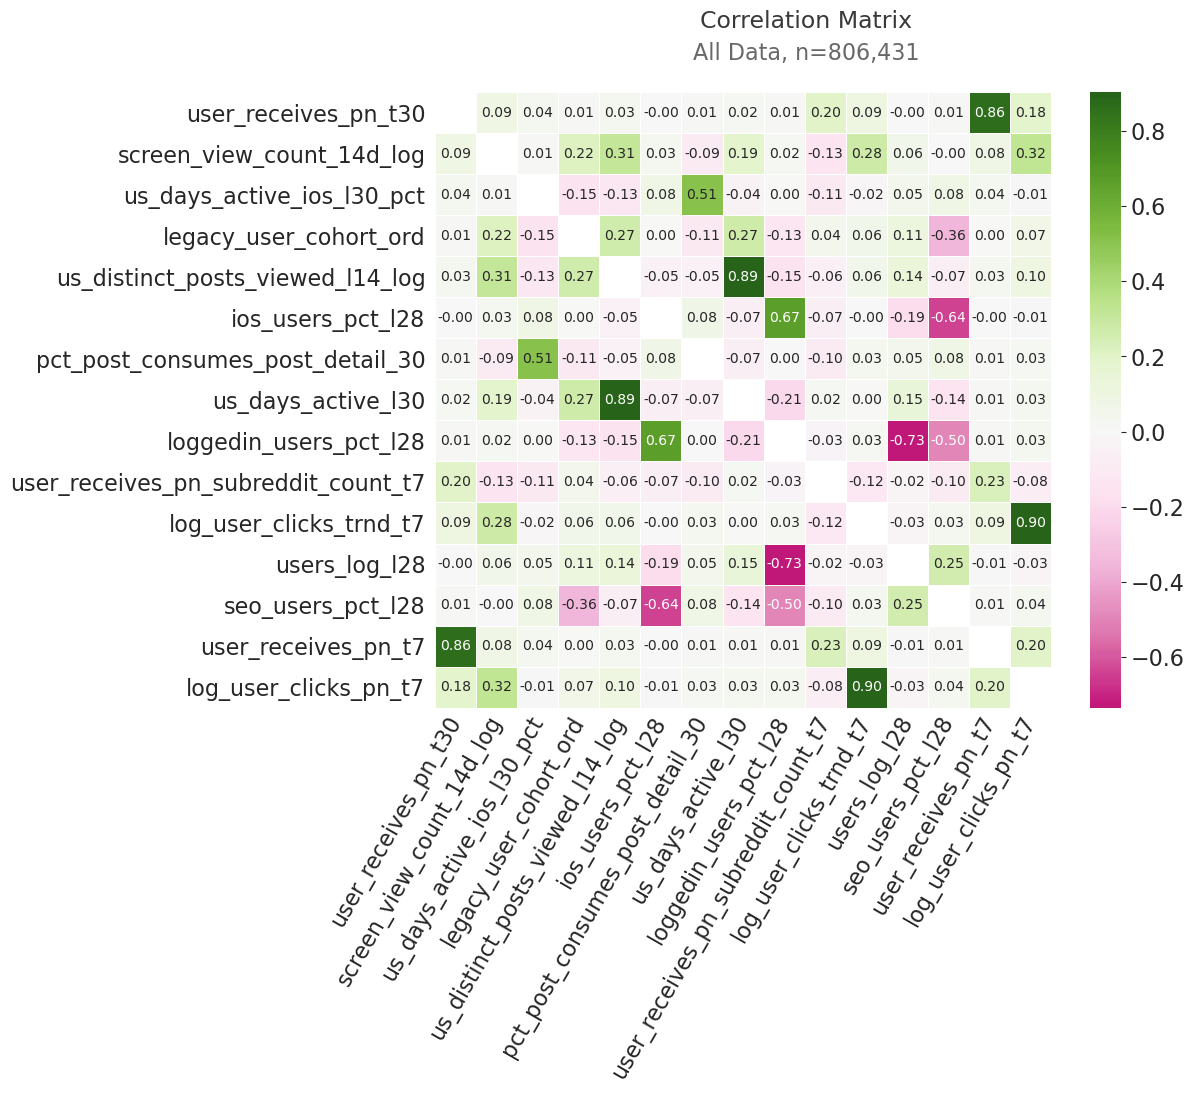

In [381]:
# Use this one that only keeps items below diagonal
#   it's also centered on zero so it's less skewed
plt.figure(figsize=(10, 8))
mask_type = 'diag'  # 'triangle' or 'diag'
try:
    l_cols_to_exclude = [
        'num_post_consumes_nsfw',
        'view_and_consume_unique_count',
        'view_count',
        'num_post_consumes_post_detail',
    ]
    print(f"Cols to exclude:\n{l_cols_to_exclude}")
    corrmat = (
        d_data_folds['X_train'][[_ for _ in l_cols_train_ordered if _ not in l_cols_to_exclude]]
        .corr()
    )
    mask = np.zeros_like(corrmat)
    if mask_type == 'triangle':
        # For triangle:
        mask[np.triu_indices_from(mask)] = True
    elif mask_type == 'diag':
        # Exclude only the diagonal:
        np.fill_diagonal(mask, 1.0)

    with sns.axes_style("white"):
        sns.heatmap(
            corrmat, center=0,
            cmap=cm.PiYG,
            mask=mask,
            annot=True,
            annot_kws={"size": 10},
            square=True,
            fmt="0.2f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        plt.xticks(rotation=60, va='center', ha='right', rotation_mode='anchor')

        plt.figtext(
            .5, .96, f"Correlation Matrix",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .92, f"All Data, n={len(d_data_folds['X_train']):,.0f}",
            fontsize=16, color='#686868', ha='center'
        )
    plt.show()
except Exception as e:
    pass

## Importance based on feature permutation
This is EXPENSIVE because we need to shuffle features AND refit a model N times.

In [382]:
from sklearn.inspection import permutation_importance

In [383]:
%%time

perm_importance = permutation_importance(
    d_search_fit['xgboost_pre1'].best_estimator_,
    X_test, d_data_folds['y_test'], n_repeats=10, random_state=42, n_jobs=-1
)

CPU times: user 5.56 s, sys: 1.78 s, total: 7.35 s
Wall time: 27.9 s


In [384]:
# list(d_search_fit['rf'].best_estimator_['preprocess'].transformers_[0][1].get_feature_names())

In [385]:
len(l_train_cols_num)

38

In [386]:
# try to get feature names from pipeline, otherwise from X_train
try:
    ftr_names_ = d_search_fit['xgboost_pre1'].best_estimator_['preprocess'].get_feature_names_out()
    # sometimes there are double underscores if we used an encoder like: OneHotEncoder
    ftr_names_ = [
        '__'.join(_.split('__')[1:]) if '__' in _ else _ for _ in ftr_names_
    ]
    info(f"Got names from pipeline")
except KeyError:
    info(f"Got names from X_train")
    ftr_names_ = list(d_data_folds['X_train'].columns)
        
df_importances_p = (
    pd.DataFrame(
        {
            'feature_names': ftr_names_,
            'importances': perm_importance.importances_mean,
            'std': perm_importance.importances_std,
        }
    )
    .sort_values(by=['importances'], ascending=False)
)
print(df_importances_p.shape)
df_importances_p.head(20)

08:25:01 | INFO | "Got names from pipeline"


(40, 3)


,feature_names,importances,std
7,log_post_consumes_30,0.036001,0.000625
8,log_num_post_consumes_home_30,0.008747,0.000230
5,log_user_clicks_pn_t7,0.005796,0.000328
14,pct_post_consumes_nsfw_30,0.001297,0.000142
19,us_screenviews_l14_log,0.001295,0.000152
21,us_post_screenviews_l14_log,0.000644,0.000072
1,user_receives_pn_subreddit_count_t7,0.000329,0.000075
39,subscribed,0.000292,0.000120
29,us_sessions_l14,-0.000030,0.000024
28,us_trend_pn_click_l14,-0.000113,0.000039


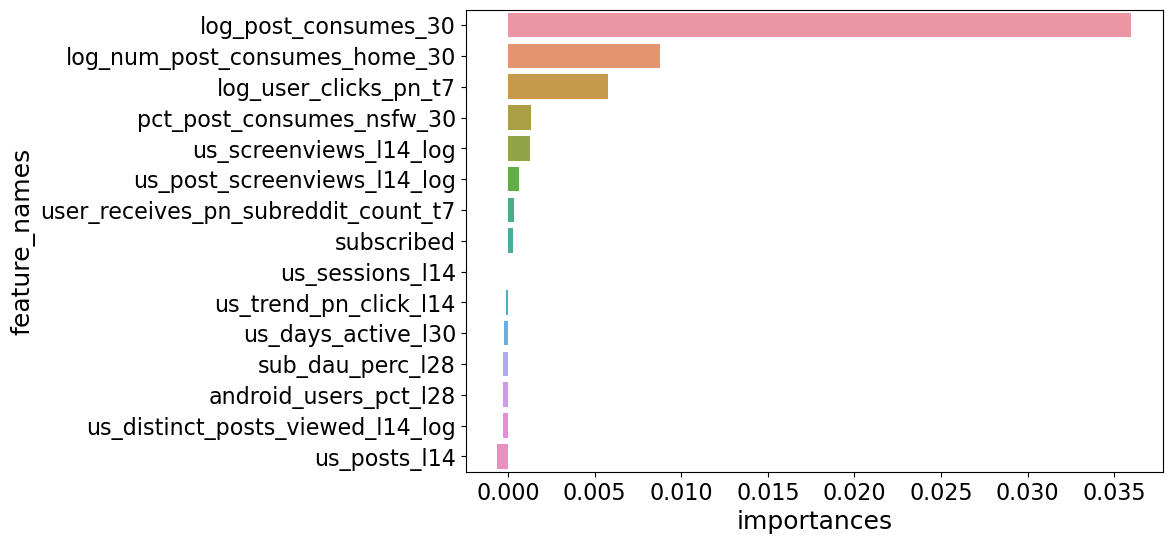

In [387]:
ax = sns.barplot(
    data=df_importances_p.head(15),
    x='importances',
    y='feature_names',
)

<BarContainer object of 15 artists>

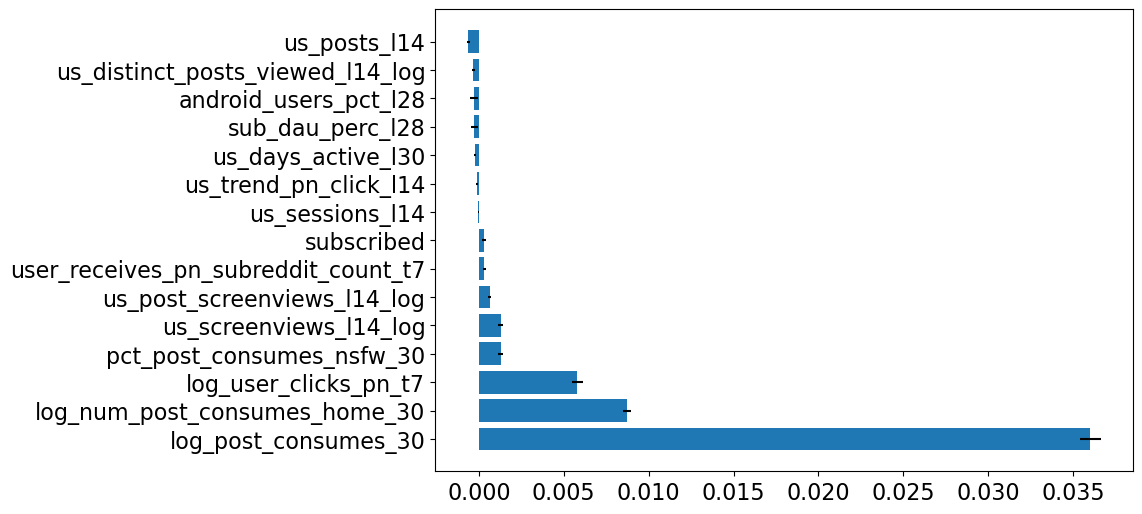

In [388]:

plt.barh(
    y=df_importances_p.head(15)['feature_names'],
    width=df_importances_p.head(15)['importances'],
    xerr=df_importances_p.head(15)['std'],
)

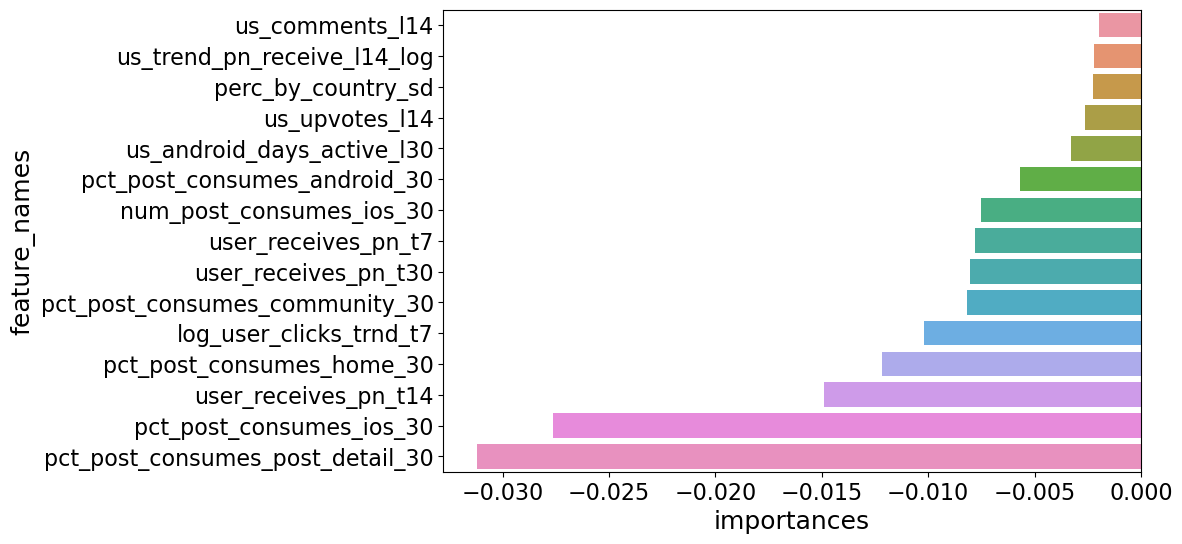

In [389]:
ax = sns.barplot(
    data=df_importances_p.tail(15),
    x='importances',
    y='feature_names',
)

In [390]:
df_importances_p.tail(10)

,feature_names,importances,std
13,pct_post_consumes_android_30,-0.005686,0.000252
15,num_post_consumes_ios_30,-0.007502,0.000140
2,user_receives_pn_t7,-0.007788,0.000246
4,user_receives_pn_t30,-0.008048,0.000280
10,pct_post_consumes_community_30,-0.008153,0.000365
6,log_user_clicks_trnd_t7,-0.010174,0.000272
9,pct_post_consumes_home_30,-0.012157,0.000291
3,user_receives_pn_t14,-0.014878,0.000168
12,pct_post_consumes_ios_30,-0.027650,0.000419
11,pct_post_consumes_post_detail_30,-0.031227,0.000326


In [395]:
df_importances_p.head(20)['feature_names'].to_list()

['log_post_consumes_30',
 'log_num_post_consumes_home_30',
 'log_user_clicks_pn_t7',
 'pct_post_consumes_nsfw_30',
 'us_screenviews_l14_log',
 'us_post_screenviews_l14_log',
 'user_receives_pn_subreddit_count_t7',
 'subscribed',
 'us_sessions_l14',
 'us_trend_pn_click_l14',
 'us_days_active_l30',
 'sub_dau_perc_l28',
 'android_users_pct_l28',
 'us_distinct_posts_viewed_l14_log',
 'us_posts_l14',
 'us_ios_days_active_l30',
 'num_post_consumes_android_30',
 'legacy_user_cohort_ord',
 'screen_view_count_14d_log',
 'seo_users_pct_l28']

# Appendix

### Clicks - other cuts

In [398]:
q_bins = 4
fill_na_val = -1

l_important_num_cols = [
    'log_post_consumes_30',
    'log_num_post_consumes_home_30',
    'log_user_clicks_pn_t7',
    'pct_post_consumes_nsfw_30',
    'us_screenviews_l14_log',
    'us_post_screenviews_l14_log',
    'user_receives_pn_subreddit_count_t7',

    'us_sessions_l14',
    'us_trend_pn_click_l14',
    'us_days_active_l30',
    'sub_dau_perc_l28',
    'android_users_pct_l28',
    'us_distinct_posts_viewed_l14_log',
    'us_posts_l14',
    'us_ios_days_active_l30',
    'num_post_consumes_android_30',
    'screen_view_count_14d_log',
    # 'seo_users_pct_l28'
]
l_cols_to_bin_ = l_important_num_cols
# [
#     'tos_sub_count', 'screen_view_count_14d',
#     'user_receives_pn_t7', 'user_clicks_pn_t7', 'user_clicks_trnd_t7',
    
#     'num_post_consumes', 'num_post_consumes_community',
#     'pct_post_consumes_nsfw',
    
#     'view_and_consume_unique_count',
#     'cosine_similarity'
# ]
pctiles_ = [0.25, 0.333, 0.5, 0.6667, 0.75]
for c_to_bin_ in l_cols_to_bin_:
    c_new_ = f"{c_to_bin_}_bin"
    print(f"\n== {c_to_bin_} ==")
     
    null_count_ = df_train[c_to_bin_].isnull().sum()
    display(style_df_numeric(df_train[c_to_bin_].describe(percentiles=pctiles_).to_frame().T))
    
    if null_count_ > 1:
        # min_val_ = min([fill_na_val, df_train[c_to_bin_].min()])
        display(style_df_numeric(df_train[c_to_bin_].fillna(fill_na_val).describe(percentiles=pctiles_).to_frame().T))
    else:
        # min_val_ = df_train[c_to_bin_].min()
        pass
    

    # Try to make better bins... ?
#     max_val_ = df_train[c_to_bin_].max()
        
#     if min_val_ < 0:
#         bins_ = 
#     else:
#         bins_ = 
    
    display(
        value_counts_and_pcts(
            (
                df_train
                .assign(
                    **{
                        c_new_: pd.qcut(
                            df_train[c_to_bin_].fillna(fill_na_val),
                            q=q_bins,
                            duplicates='drop',
                        )
                    }
                )
                [df_train['click'] == 1]
            ),
            [c_new_, 'click'],
            sort_index=True,
            top_n=None,
            pct_digits=3,
        )
    )



== log_post_consumes_30 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
log_post_consumes_30,"1,152,045",6.88,2.92,0.00,5.60,6.55,7.80,8.65,9.02,12.35


,,count,percent,cumulative_percent
log_post_consumes_30_bin,click,,,
"(9.023, 12.347]",1,"17,884",32.679%,32.679%
"(7.804, 9.023]",1,"16,524",30.194%,62.872%
"(5.598, 7.804]",1,"13,626",24.898%,87.770%
"(-0.001, 5.598]",1,"6,693",12.230%,100.000%



== log_num_post_consumes_home_30 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
log_num_post_consumes_home_30,"1,152,045",5.95,3.05,0.00,4.03,5.13,6.76,7.94,8.42,12.05


,,count,percent,cumulative_percent
log_num_post_consumes_home_30_bin,click,,,
"(8.423, 12.055]",1,"18,388",33.600%,33.600%
"(6.76, 8.423]",1,"17,258",31.535%,65.134%
"(4.025, 6.76]",1,"13,099",23.935%,89.069%
"(-0.001, 4.025]",1,"5,982",10.931%,100.000%



== log_user_clicks_pn_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
log_user_clicks_pn_t7,"1,152,045",0.82,1.08,0.00,0.00,0.00,0.00,1.10,1.61,7.61


,,count,percent,cumulative_percent
log_user_clicks_pn_t7_bin,click,,,
"(1.609, 7.608]",1,"36,929",67.479%,67.479%
"(-0.001, 1.609]",1,"17,798",32.521%,100.000%



== pct_post_consumes_nsfw_30 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
pct_post_consumes_nsfw_30,"1,056,830",0.23,0.29,0.00,0.02,0.04,0.08,0.21,0.36,1.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
pct_post_consumes_nsfw_30,"1,152,045",0.13,0.44,-1.00,0.01,0.03,0.07,0.17,0.31,1.00


,,count,percent,cumulative_percent
pct_post_consumes_nsfw_30_bin,click,,,
"(0.308, 1.0]",1,"9,483",17.328%,17.328%
"(0.0665, 0.308]",1,"16,987",31.040%,48.367%
"(0.0112, 0.0665]",1,"18,475",33.758%,82.126%
"(-1.001, 0.0112]",1,"9,782",17.874%,100.000%



== us_screenviews_l14_log ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_screenviews_l14_log,"456,066",0.24,0.78,0.00,0.00,0.00,0.00,0.00,0.00,7.64


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_screenviews_l14_log,"1,152,045",-0.51,0.78,-1.00,-1.00,-1.00,-1.00,0.00,0.00,7.64


,,count,percent,cumulative_percent
us_screenviews_l14_log_bin,click,,,
"(0.0, 7.639]",1,"4,362",7.970%,7.970%
"(-1.001, 0.0]",1,"50,365",92.030%,100.000%



== us_post_screenviews_l14_log ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_post_screenviews_l14_log,"456,066",1.01,1.39,0.00,0.00,0.00,0.00,1.10,1.61,8.23


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_post_screenviews_l14_log,"1,152,045",-0.21,1.31,-1.00,-1.00,-1.00,-1.00,0.00,0.00,8.23


,,count,percent,cumulative_percent
us_post_screenviews_l14_log_bin,click,,,
"(0.0, 8.226]",1,"16,153",29.516%,29.516%
"(-1.001, 0.0]",1,"38,574",70.484%,100.000%



== user_receives_pn_subreddit_count_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_receives_pn_subreddit_count_t7,"1,152,045",5.48,4.17,0.00,2.00,3.00,5.00,7.00,8.00,207.00


,,count,percent,cumulative_percent
user_receives_pn_subreddit_count_t7_bin,click,,,
"(8.0, 207.0]",1,"5,633",10.293%,10.293%
"(5.0, 8.0]",1,"7,706",14.081%,24.374%
"(2.0, 5.0]",1,"18,475",33.758%,58.132%
"(-0.001, 2.0]",1,"22,913",41.868%,100.000%



== us_sessions_l14 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_sessions_l14,"320,346",6.24,11.73,0.00,1.00,1.00,1.00,3.00,6.00,394.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_sessions_l14,"1,152,045",1.01,6.98,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,394.00


,,count,percent,cumulative_percent
us_sessions_l14_bin,click,,,
"(0.0, 394.0]",1,"18,011",32.911%,32.911%
"(-1.001, 0.0]",1,"36,716",67.089%,100.000%



== us_trend_pn_click_l14 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_trend_pn_click_l14,"320,346",0.29,2.40,0.00,0.00,0.00,0.00,0.00,0.00,196.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_trend_pn_click_l14,"1,152,045",-0.64,1.39,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,196.00


,,count,percent,cumulative_percent
us_trend_pn_click_l14_bin,click,,,
"(0.0, 196.0]",1,"1,953",3.569%,3.569%
"(-1.001, 0.0]",1,"52,774",96.431%,100.000%



== us_days_active_l30 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_days_active_l30,"335,200",6.39,8.05,1.00,1.00,1.00,2.00,5.00,8.00,30.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_days_active_l30,"1,152,045",1.15,5.49,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,30.00


,,count,percent,cumulative_percent
us_days_active_l30_bin,click,,,
"(1.0, 30.0]",1,"15,125",27.637%,27.637%
"(-1.001, 1.0]",1,"39,602",72.363%,100.000%



== sub_dau_perc_l28 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
sub_dau_perc_l28,"456,066",0.49,0.26,-0.10,0.27,0.34,0.50,0.62,0.62,0.98


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
sub_dau_perc_l28,"1,152,045",-0.41,0.75,-1.00,-1.00,-1.00,-1.00,0.25,0.36,0.98


,,count,percent,cumulative_percent
sub_dau_perc_l28_bin,click,,,
"(0.36, 0.984]",1,"13,105",23.946%,23.946%
"(-1.001, 0.36]",1,"41,622",76.054%,100.000%



== android_users_pct_l28 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
android_users_pct_l28,"1,152,045",0.25,0.09,0.13,0.21,0.22,0.22,0.24,0.24,0.46


,,count,percent,cumulative_percent
android_users_pct_l28_bin,click,,,
"(0.237, 0.456]",1,"8,847",16.166%,16.166%
"(0.224, 0.237]",1,"15,194",27.763%,43.929%
"(0.213, 0.224]",1,"14,196",25.940%,69.869%
"(0.125, 0.213]",1,"16,490",30.131%,100.000%



== us_distinct_posts_viewed_l14_log ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_distinct_posts_viewed_l14_log,"456,066",0.87,1.21,0.00,0.00,0.00,0.00,0.69,1.39,7.63


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_distinct_posts_viewed_l14_log,"1,152,045",-0.26,1.19,-1.00,-1.00,-1.00,-1.00,0.00,0.00,7.63


,,count,percent,cumulative_percent
us_distinct_posts_viewed_l14_log_bin,click,,,
"(0.0, 7.629]",1,"16,152",29.514%,29.514%
"(-1.001, 0.0]",1,"38,575",70.486%,100.000%



== us_posts_l14 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_posts_l14,"320,346",0.01,0.24,0.00,0.00,0.00,0.00,0.00,0.00,70.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_posts_l14,"1,152,045",-0.72,0.47,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,70.00


,,count,percent,cumulative_percent
us_posts_l14_bin,click,,,
"(0.0, 70.0]",1,166,0.303%,0.303%
"(-1.001, 0.0]",1,"54,561",99.697%,100.000%



== us_ios_days_active_l30 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_ios_days_active_l30,"335,200",2.04,5.35,0.00,0.00,0.00,0.00,1.00,1.00,30.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
us_ios_days_active_l30,"1,152,045",-0.12,3.20,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,30.00


,,count,percent,cumulative_percent
us_ios_days_active_l30_bin,click,,,
"(0.0, 30.0]",1,"7,783",14.221%,14.221%
"(-1.001, 0.0]",1,"46,944",85.779%,100.000%



== num_post_consumes_android_30 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
num_post_consumes_android_30,"1,152,045","3,507.88","6,842.36",0.00,0.00,0.00,182.00,"1,952.73","4,020.00","175,477.00"


,,count,percent,cumulative_percent
num_post_consumes_android_30_bin,click,,,
"(4020.0, 175477.0]",1,"17,712",32.364%,32.364%
"(182.0, 4020.0]",1,"14,250",26.038%,58.403%
"(-0.001, 182.0]",1,"22,765",41.597%,100.000%



== screen_view_count_14d_log ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
screen_view_count_14d_log,"1,152,045",2.52,0.89,0.00,2.30,2.64,2.94,3.09,3.09,3.09


,,count,percent,cumulative_percent
screen_view_count_14d_log_bin,click,,,
"(2.944, 3.091]",1,"40,741",74.444%,74.444%
"(2.303, 2.944]",1,"10,608",19.383%,93.828%
"(-0.001, 2.303]",1,"3,378",6.172%,100.000%
